In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
import skimage, torch, torchvision
import pickle 
import cv2
from tqdm import tqdm
import random
from torch.utils.data import Dataset
import os
import random
import itertools
from torcheval.metrics import BinaryAccuracy, BinaryAUROC
from torcheval.metrics import MulticlassAccuracy, MulticlassAUROC
import seaborn as sns

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Waterbirds

In [22]:
import scipy.stats as st
# Calculate 95% confidence intervals with Student t's continuous random variable 
def calculate_CI(df, names, seeds):
    df['lower_95'] = 0
    df['upper_95'] = 0
    df['lower_95_err'] = 0
    df['upper_95_err'] = 0
    for name in names: 
        if name == "oracle": 
            df.loc[name, 'lower_95'] = df.loc[name, 'mean']
            df.loc[name, 'upper_95'] = df.loc[name, 'mean']
            df.loc[name, 'lower_95_err'] = 0
            df.loc[name, 'upper_95_err'] = 0
        else:
            data = df.loc[name, seeds].dropna()
            lower, upper = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
            df.loc[name, 'lower_95'] = lower
            df.loc[name, 'upper_95'] = upper
            df.loc[name, 'lower_95_err'] = df.loc[name, 'mean'] - lower
            df.loc[name, 'upper_95_err'] = upper - df.loc[name, 'mean']
    return df

In [3]:
with open("waterbirds_preprocessed_datasets_classifier_pil.pkl", "rb") as f: 
    preprocessed_datasets = pickle.load(f)

In [46]:
# All is pre-transfer results 

names = [
         # "base",
         # "cutmix", 
         # "mixup", 
         # "diffusion-background",
         # "oracle", 
          "base-ablation_5", 
           "base-ablation_10", 
            "base-ablation_25",
            "base-ablation_50", 
            "base-ablation_100",
            # "diffusion-ablation_1000", 
            # "diffusion-ablation_2500", 
          ]
seeds = [0, 1, 2, 3, 4]


acc_metric = BinaryAccuracy()
auc_metric = BinaryAUROC()
groups = np.array(preprocessed_datasets['test'].groups)
indomain =  (groups == 0) | (groups == 3)
outdomain = (groups == 1) | (groups == 2)

df_aucs = pd.DataFrame(index=names, columns = seeds)
df_in_auc = pd.DataFrame(index=names, columns = seeds)
df_out_auc = pd.DataFrame(index=names, columns = seeds)

df_bacc = pd.DataFrame(index=names, columns = seeds)
df_in_acc = pd.DataFrame(index=names, columns = seeds)
df_out_acc = pd.DataFrame(index=names, columns = seeds)

for name in names: 
    for seed in seeds: 
        if name == "oracle": 
            output_dir = "/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/oracle"
        elif "ablation" in name: 
            output_dir = f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/{name.split('_')[0]}_seed{seed}/{name.split('_')[1]}/transfer"
        else:
            output_dir = f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/{name}_seed{seed}"

        if not os.path.exists(f"{output_dir}/test_outputs.pkl"): 
            continue
        with open(f"{output_dir}/test_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/test_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)

        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_aucs.loc[name, seed] = auc_metric.compute().item()

        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_auc.loc[name, seed] = auc_metric.compute().item()
        
        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_auc.loc[name, seed] = auc_metric.compute().item()

        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_bacc.loc[name, seed] = acc_metric.compute().item()
        
        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_acc.loc[name, seed] = acc_metric.compute().item()
        
        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_acc.loc[name, seed] = acc_metric.compute().item()

In [47]:
df_aucs['mean'] = df_aucs.mean(axis=1)
df_aucs['std'] = df_aucs.std(axis=1)
df_in_auc['mean'] = df_in_auc.mean(axis=1)
df_in_auc['std'] = df_in_auc.std(axis=1)
df_out_auc['mean'] = df_out_acc.mean(axis=1)
df_out_auc['std'] = df_out_acc.std(axis=1)

df_bacc['mean'] = df_bacc.mean(axis=1)
df_bacc['std'] = df_bacc.std(axis=1)
df_in_acc['mean'] = df_in_acc.mean(axis=1)
df_in_acc['std'] = df_in_acc.std(axis=1)
df_out_acc['mean'] = df_out_acc.mean(axis=1)
df_out_acc['std'] = df_out_acc.std(axis=1)

In [48]:
df_aucs = calculate_CI(df_aucs, names, seeds)
df_in_auc = calculate_CI(df_in_acc, names, seeds)
df_out_auc = calculate_CI(df_out_acc, names, seeds)

df_bacc = calculate_CI(df_bacc, names, seeds)
df_in_acc = calculate_CI(df_in_acc, names, seeds)
df_out_acc = calculate_CI(df_out_acc, names, seeds)

In [239]:
# df_aucs.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_aucs.csv")
# df_in_auc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_in_aucs.csv")
# df_out_auc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_out_aucs.csv")

# df_bacc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_baccs.csv")
# df_in_acc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_in_accs.csv")
# df_out_acc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_out_accs.csv")

In [49]:
df_bacc

,0,1,2,3,4,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
base-ablation_5,0.639109,0.668968,0.617881,0.658095,0.625992,0.642009,0.019145,0.615432,0.668586,0.026577,0.026577
base-ablation_10,0.637038,0.675009,0.695029,0.675181,0.668105,0.670072,0.018807,0.643965,0.696180,0.026108,0.026108
base-ablation_25,0.7563,0.689506,0.732827,0.736106,0.6971,0.722368,0.025171,0.687425,0.757311,0.034943,0.034943
base-ablation_50,0.7903,0.79824,0.744909,0.717466,0.788574,0.767898,0.031375,0.724343,0.811453,0.043555,0.043555
base-ablation_100,0.817915,0.844149,0.853297,0.807042,0.853814,0.835243,0.019213,0.808571,0.861915,0.026672,0.026672


In [50]:
df_in_acc

,0,1,2,3,4,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
base-ablation_5,0.947877,0.943045,0.948913,0.953055,0.944425,0.947463,0.00353,0.942563,0.952363,0.004900,0.004900
base-ablation_10,0.939593,0.952365,0.954436,0.949258,0.950984,0.949327,0.005154,0.942172,0.956482,0.007155,0.007155
base-ablation_25,0.959959,0.94408,0.953055,0.950293,0.942009,0.949879,0.006441,0.940938,0.958820,0.008941,0.008941
base-ablation_50,0.944425,0.936141,0.928547,0.921298,0.952365,0.936555,0.011036,0.921235,0.951875,0.015320,0.015320
base-ablation_100,0.935105,0.939938,0.950293,0.927166,0.948568,0.940214,0.008577,0.928308,0.952120,0.011906,0.011906


In [51]:
df_out_acc

,0,1,2,3,4,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
base-ablation_5,0.330342,0.394891,0.286848,0.363134,0.30756,0.336555,0.038626,0.282934,0.390176,0.053621,0.053621
base-ablation_10,0.334484,0.397653,0.435623,0.401105,0.385226,0.390818,0.032756,0.345345,0.436291,0.045473,0.045473
base-ablation_25,0.552641,0.434933,0.512599,0.521919,0.452192,0.494857,0.044266,0.433406,0.556308,0.061451,0.061451
base-ablation_50,0.636175,0.660338,0.56127,0.513635,0.624784,0.599241,0.053888,0.524432,0.674049,0.074809,0.074809
base-ablation_100,0.700725,0.74836,0.7563,0.686917,0.759061,0.730273,0.030286,0.688230,0.772316,0.042043,0.042043


In [52]:
ablation_dir = "/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/base-ablation_results/"
if not os.path.exists(ablation_dir): 
    os.makedirs(ablation_dir)

In [53]:
df_aucs.to_csv(f"{ablation_dir}/source_aucs.csv")
df_in_auc.to_csv(f"{ablation_dir}/source_in_aucs.csv")
df_out_auc.to_csv(f"{ablation_dir}/source_out_aucs.csv")

df_bacc.to_csv(f"{ablation_dir}/source_baccs.csv")
df_in_acc.to_csv(f"{ablation_dir}/source_in_accs.csv")
df_out_acc.to_csv(f"{ablation_dir}/source_out_accs.csv")

In [436]:
# Transfer results 
names = ["base"
]
seeds = [0, 1, 2, 3, 4]

acc_metric = BinaryAccuracy()
auc_metric = BinaryAUROC()
groups = np.array(preprocessed_datasets['test'].groups)
indomain =  (groups == 0) | (groups == 3)
outdomain = (groups == 1) | (groups == 2)

df_aucs = pd.DataFrame(index=names, columns = seeds)
df_in_auc = pd.DataFrame(index=names, columns = seeds)
df_out_auc = pd.DataFrame(index=names, columns = seeds)
df_bacc = pd.DataFrame(index=names, columns = seeds)
df_in_acc = pd.DataFrame(index=names, columns = seeds)
df_out_acc = pd.DataFrame(index=names, columns = seeds)

for name in names: 
    for seed in seeds: 
        if name == "oracle": 
            output_dir = "/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/oracle"
        else:
            output_dir = f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/{name}_seed{seed}/transfer"

        with open(f"{output_dir}/test_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/test_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)

        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_aucs.loc[name, seed] = auc_metric.compute().item()

        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_auc.loc[name, seed] = auc_metric.compute().item()
        
        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_auc.loc[name, seed] = auc_metric.compute().item()
        
        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_bacc.loc[name, seed] = acc_metric.compute().item()

        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_acc.loc[name, seed] = acc_metric.compute().item()
        
        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_acc.loc[name, seed] = acc_metric.compute().item()

In [437]:
df_aucs['mean'] = df_aucs.mean(axis=1)
df_aucs['std'] = df_aucs.std(axis=1)
df_in_auc['mean'] = df_in_auc.mean(axis=1)
df_in_auc['std'] = df_in_auc.std(axis=1)
df_out_auc['mean'] = df_out_acc.mean(axis=1)
df_out_auc['std'] = df_out_acc.std(axis=1)

df_bacc['mean'] = df_bacc.mean(axis=1)
df_bacc['std'] = df_bacc.std(axis=1)
df_in_acc['mean'] = df_in_acc.mean(axis=1)
df_in_acc['std'] = df_in_acc.std(axis=1)
df_out_acc['mean'] = df_out_acc.mean(axis=1)
df_out_acc['std'] = df_out_acc.std(axis=1)

In [440]:
df_bacc

,0,1,2,3,4,mean,std
base,0.759579,0.759406,0.765965,0.758716,0.752675,0.759268,0.004213


In [441]:
df_in_acc

,0,1,2,3,4,mean,std
base,0.772869,0.824991,0.790128,0.822575,0.799103,0.801933,0.019748


In [439]:
df_out_acc

,0,1,2,3,4,mean,std
base,0.746289,0.693821,0.741802,0.694857,0.706248,0.716603,0.022871


In [54]:
# df_aucs = calculate_CI(df_aucs, names, seeds)
# df_in_auc = calculate_CI(df_in_acc, names, seeds)
# df_out_auc = calculate_CI(df_out_acc, names, seeds)

# df_bacc = calculate_CI(df_bacc, names, seeds)
# df_in_acc = calculate_CI(df_in_acc, names, seeds)
# df_out_acc = calculate_CI(df_out_acc, names, seeds)

In [98]:
# df_aucs.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_aucs.csv")
# df_in_auc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_in_aucs.csv")
# df_out_auc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_out_aucs.csv")

# df_bacc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_baccs.csv")
# df_in_acc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_in_accs.csv")
# df_out_acc.to_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_out_accs.csv")

## Combine Accuracy results

In [374]:
# df_target_bacc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_baccs.csv", index_col=0)
# df_target_in_acc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_in_accs.csv", index_col=0)
# df_target_out_acc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_out_accs.csv", index_col=0)

In [243]:
df_source_bacc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_baccs.csv", index_col=0)
df_source_in_acc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_in_accs.csv", index_col=0)
df_source_out_acc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_out_accs.csv", index_col=0)

df_source_aucs = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_aucs.csv", index_col=0)
df_source_in_auc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_in_aucs.csv", index_col=0)
df_source_out_auc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_out_aucs.csv", index_col=0)

In [247]:
df_source_bacc.index = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']
df_source_in_acc.index = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']
df_source_out_acc.index = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']

df_source_aucs.index = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']
df_source_in_auc.index = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']
df_source_out_auc.index = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']

In [377]:
# df_target_bacc.index = ['base+extra', 'dreambooth+extra', 'oracle']
# df_target_in_acc.index = ['base+extra', 'dreambooth+extra', 'oracle']
# df_target_out_acc.index = ['base+extra', 'dreambooth+extra', 'oracle']

In [378]:
# df_bacc = pd.concat([df_source_bacc.loc[['base', 'cutmix', 'mixup', 'dreambooth']], 
#                      df_target_bacc.loc[['base+extra', 'dreambooth+extra']]])
# df_in_acc = pd.concat([df_source_in_acc.loc[['base', 'cutmix', 'mixup', 'dreambooth']], 
#                      df_target_in_acc.loc[['base+extra', 'dreambooth+extra']]])
# df_out_acc = pd.concat([df_source_out_acc.loc[['base', 'cutmix', 'mixup', 'dreambooth']], 
#                      df_target_out_acc.loc[['base+extra', 'dreambooth+extra']]])

In [231]:
df_source_bacc.to_csv("results/table_waterbirds_bacc.csv")
df_source_in_acc.to_csv("results/table_waterbirds_in_acc.csv")
df_source_out_acc.to_csv("results/table_waterbirds_out_acc.csv")

df_source_aucs.to_csv("results/table_waterbirds_aucs.csv")
df_source_in_auc.to_csv("results/table_waterbirds_in_auc.csv")
df_source_out_auc.to_csv("results/table_waterbirds_out_auc.csv")

In [21]:
df_source_bacc = pd.read_csv("results/table_waterbirds_bacc.csv", index_col=0)
df_source_in_acc = pd.read_csv("results/table_waterbirds_in_acc.csv", index_col=0)
df_source_out_acc = pd.read_csv("results/table_waterbirds_out_acc.csv", index_col=0)

df_source_aucs = pd.read_csv("results/table_waterbirds_aucs.csv", index_col=0)
df_source_in_auc = pd.read_csv("results/table_waterbirds_in_auc.csv", index_col=0)
df_source_out_auc = pd.read_csv("results/table_waterbirds_out_auc.csv", index_col=0)

In [22]:
df_bacc = df_source_bacc
df_in_acc = df_source_in_acc
df_out_acc = df_source_out_acc

df_aucs = df_source_aucs 
df_in_auc = df_source_in_auc
df_out_auc = df_source_out_auc

In [30]:
models = ['Base', 'CutMix', 'MixUp', 'MaskMedPaint']

In [42]:
df_bacc = df_bacc.loc[models]
df_in_acc = df_in_acc.loc[models]
df_out_acc = df_out_acc.loc[models]

df_aucs = df_aucs.loc[models]
df_in_auc = df_in_auc.loc[models]
df_out_auc = df_out_auc.loc[models]

In [19]:
sns.set_style("whitegrid")

/tmp/ipykernel_1848278/2676456378.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df_bacc,x=df_bacc.index, y="mean", hue=df_bacc.index, edgecolor=".5",


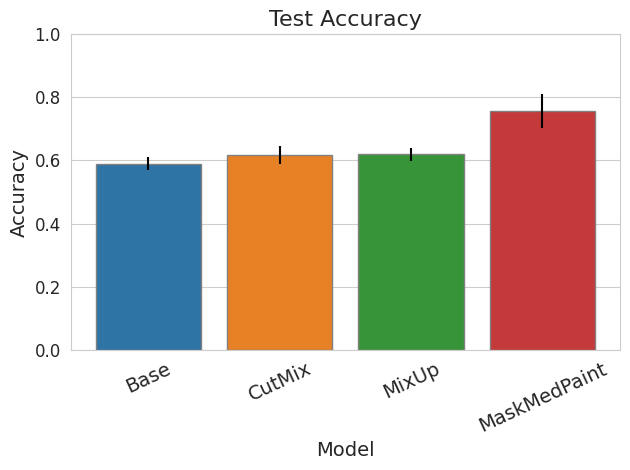

In [37]:
ax = sns.barplot(df_bacc,x=df_bacc.index, y="mean", hue=df_bacc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_bacc.index, y=df_bacc["mean"], 
            yerr = df_bacc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.yticks(fontsize=12)
plt.xticks(rotation=25, fontsize=14)
plt.tight_layout()
plt.savefig("results/waterbirds_acc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/2614171228.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df_in_acc,x=df_in_acc.index, y="mean", hue=df_in_acc.index, edgecolor=".5",


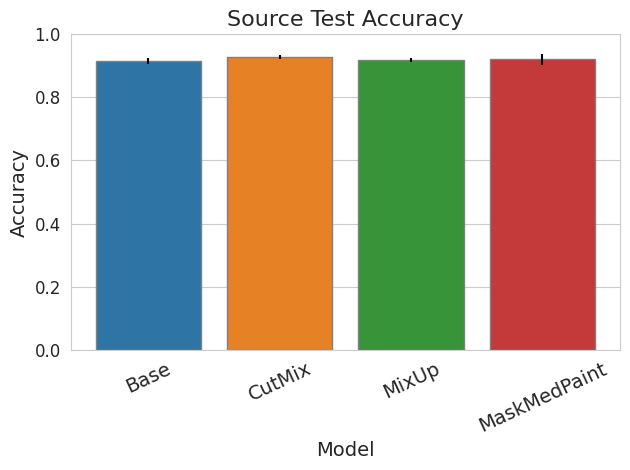

In [39]:
ax = sns.barplot(df_in_acc,x=df_in_acc.index, y="mean", hue=df_in_acc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_in_acc.index, y=df_in_acc["mean"], yerr = df_in_acc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Source Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.yticks(fontsize=12)
plt.xticks(rotation=25, fontsize=14)
plt.tight_layout()
plt.savefig("results/waterbirds_in_acc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/3154505452.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df_out_acc,x=df_out_acc.index, y="mean", hue=df_out_acc.index, edgecolor=".5",


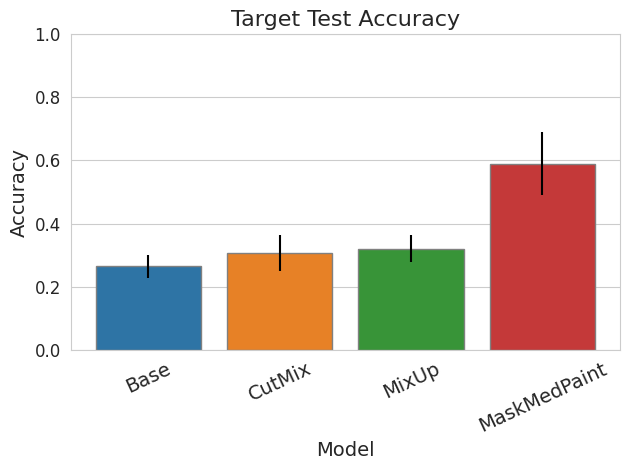

In [40]:
ax = sns.barplot(df_out_acc,x=df_out_acc.index, y="mean", hue=df_out_acc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_out_acc.index, y=df_out_acc["mean"], yerr = df_out_acc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Target Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.yticks(fontsize=12)
plt.xticks(rotation=25, fontsize=14)
plt.tight_layout()
plt.savefig("results/waterbirds_out_acc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/3195681764.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df_aucs,x=df_aucs.index, y="mean", hue=df_aucs.index, edgecolor=".5",


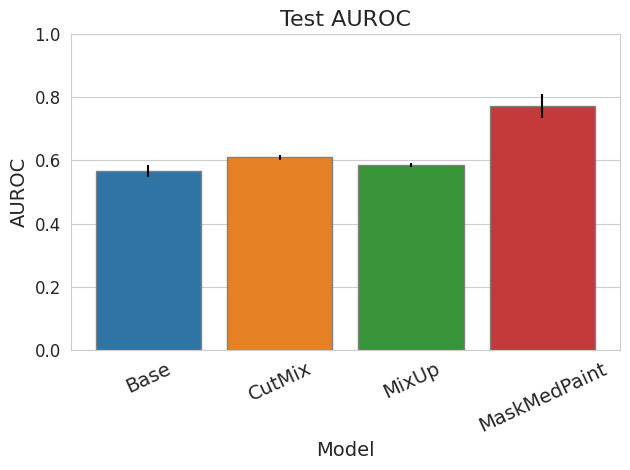

In [43]:
ax = sns.barplot(df_aucs,x=df_aucs.index, y="mean", hue=df_aucs.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_aucs.index, y=df_aucs["mean"], yerr = df_aucs[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Test AUROC", fontsize=16)
plt.ylabel("AUROC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.yticks(fontsize=12)
plt.xticks(rotation=25, fontsize=14)
plt.tight_layout()
plt.savefig("results/waterbirds_auc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/793787027.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df_in_auc,x=df_in_auc.index, y="mean", hue=df_in_auc.index, edgecolor=".5",


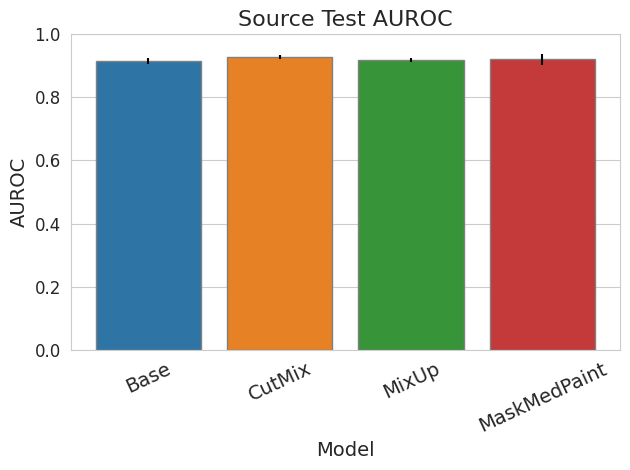

In [44]:
ax = sns.barplot(df_in_auc,x=df_in_auc.index, y="mean", hue=df_in_auc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_in_auc.index, y=df_in_auc["mean"], yerr = df_in_auc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Source Test AUROC", fontsize=16)
plt.ylabel("AUROC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.yticks(fontsize=12)
plt.xticks(rotation=25, fontsize=14)
plt.tight_layout()
plt.savefig("results/waterbirds_in_auc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/948943740.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df_out_auc,x=df_out_auc.index, y="mean", hue=df_out_auc.index, edgecolor=".5",


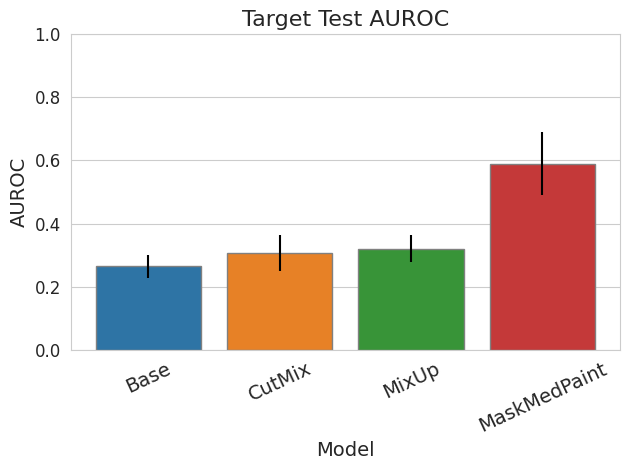

In [45]:
ax = sns.barplot(df_out_auc,x=df_out_auc.index, y="mean", hue=df_out_auc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_out_auc.index, y=df_out_auc["mean"], yerr = df_out_auc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Target Test AUROC", fontsize=16)
plt.ylabel("AUROC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.yticks(fontsize=12)
plt.xticks(rotation=25, fontsize=14)
plt.tight_layout()
plt.savefig("results/waterbirds_out_auc.png", dpi=300)
plt.show()

## Combine AUC results

In [365]:
df_target_aucs = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_aucs.csv", index_col=0)
df_target_in_auc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_in_aucs.csv", index_col=0)
df_target_out_auc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/transfer_out_aucs.csv", index_col=0)

In [366]:
df_source_aucs = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_aucs.csv", index_col=0)
df_source_in_auc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_in_aucs.csv", index_col=0)
df_source_out_auc = pd.read_csv("/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/source_out_aucs.csv", index_col=0)

In [367]:
df_source_aucs.index = ['base', 'cutmix', 'mixup', 'dreambooth', 'oracle']
df_source_in_auc.index = ['base', 'cutmix', 'mixup', 'dreambooth', 'oracle']
df_source_out_auc.index = ['base', 'cutmix', 'mixup', 'dreambooth', 'oracle']

In [368]:
df_target_aucs.index = ['base+extra', 'dreambooth+extra', 'oracle']
df_target_in_auc.index = ['base+extra', 'dreambooth+extra', 'oracle']
df_target_out_auc.index = ['base+extra', 'dreambooth+extra', 'oracle']

In [369]:
df_aucs = pd.concat([df_source_aucs.loc[['base', 'cutmix', 'mixup', 'dreambooth']], 
                     df_target_aucs.loc[['base+extra', 'dreambooth+extra']]])
df_in_auc = pd.concat([df_source_in_auc.loc[['base', 'cutmix', 'mixup', 'dreambooth']], 
                     df_target_in_auc.loc[['base+extra', 'dreambooth+extra']]])
df_out_auc = pd.concat([df_source_out_auc.loc[['base', 'cutmix', 'mixup', 'dreambooth']], 
                     df_target_out_auc.loc[['base+extra', 'dreambooth+extra']]])

In [114]:
df_aucs.to_csv("results/table_waterbirds_aucs.csv")
df_in_auc.to_csv("results/table_waterbirds_in_auc.csv")
df_out_auc.to_csv("results/table_waterbirds_out_auc.csv")

/tmp/ipykernel_901384/3217123432.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(df_aucs,x=df_aucs.index, y="mean", hue=df_aucs.index, edgecolor=".5",


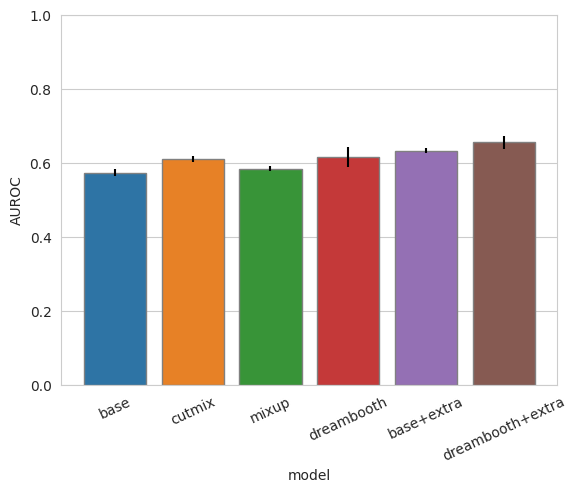

In [371]:
ax = sns.barplot(df_aucs,x=df_aucs.index, y="mean", hue=df_aucs.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_aucs.index, y=df_aucs["mean"], yerr = df_aucs[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.ylabel("AUROC")
plt.xlabel("model")
plt.ylim(0., 1.)
plt.xticks(rotation=25)
plt.savefig("results/waterbirds_auc.png", dpi=300)
plt.show()

/tmp/ipykernel_901384/3470901996.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(df_in_auc,x=df_in_auc.index, y="mean", hue=df_in_auc.index, edgecolor=".5",


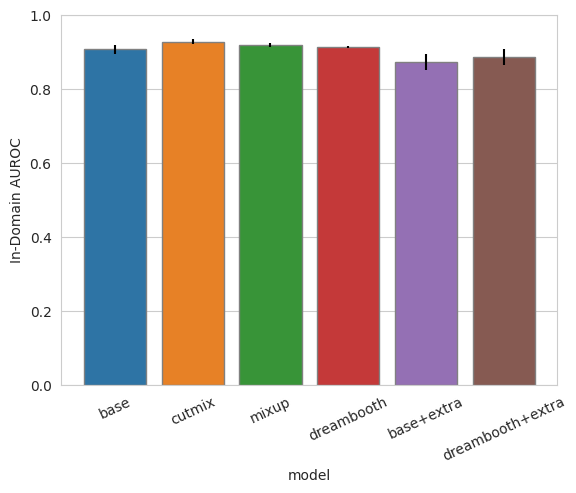

In [372]:
ax = sns.barplot(df_in_auc,x=df_in_auc.index, y="mean", hue=df_in_auc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_in_auc.index, y=df_in_auc["mean"], yerr = df_in_auc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.ylabel("In-Domain AUROC")
plt.xlabel("model")
plt.ylim(0., 1.)
plt.xticks(rotation=25)
plt.savefig("results/waterbirds_in_auc.png", dpi=300)
plt.show()

/tmp/ipykernel_901384/2384105624.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(df_out_auc,x=df_out_auc.index, y="mean", hue=df_out_auc.index, edgecolor=".5",


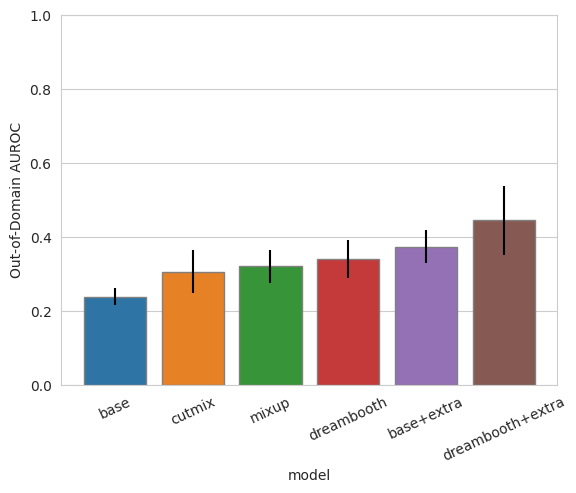

In [373]:
ax = sns.barplot(df_out_auc,x=df_out_auc.index, y="mean", hue=df_out_auc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df_out_auc.index, y=df_out_auc["mean"], yerr = df_out_auc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.ylabel("Out-of-Domain AUROC")
plt.xlabel("model")
plt.ylim(0., 1.)
plt.xticks(rotation=25)
plt.savefig("results/waterbirds_out_auc.png", dpi=300)
plt.show()

## Ablation Figs

In [46]:
res_dir = "/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/base-ablation_results"
res_dir2 = "/mnt/scratch-lids/scratch/qixuanj/waterbirds_results/diffusion-ablation_results"
res_dir3 = "results"

In [47]:
df_bacc_mean = pd.read_csv(f"{res_dir}/source_baccs.csv", index_col=0)
df_in_acc_mean = pd.read_csv(f"{res_dir}/source_in_accs.csv", index_col=0)
df_out_acc_mean = pd.read_csv(f"{res_dir}/source_out_accs.csv", index_col=0)

In [48]:
df_bacc_mean2 = pd.read_csv(f"{res_dir2}/source_baccs.csv", index_col=0)
df_in_acc_mean2 = pd.read_csv(f"{res_dir2}/source_in_accs.csv", index_col=0)
df_out_acc_mean2 = pd.read_csv(f"{res_dir2}/source_out_accs.csv", index_col=0)

In [49]:
df_bacc_mean3 = pd.read_csv(f"{res_dir3}/table_waterbirds_bacc.csv", index_col=0)
df_in_acc_mean3 = pd.read_csv(f"{res_dir3}/table_waterbirds_in_acc.csv", index_col=0)
df_out_acc_mean3 = pd.read_csv(f"{res_dir3}/table_waterbirds_out_acc.csv", index_col=0)

In [50]:
df_out_acc_mean

,0,1,2,3,4,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
base-ablation_5,0.330342,0.394891,0.286848,0.363134,0.307560,0.336555,0.038626,0.282934,0.390176,0.053621,0.053621
base-ablation_10,0.334484,0.397653,0.435623,0.401105,0.385226,0.390818,0.032756,0.345345,0.436291,0.045473,0.045473
base-ablation_25,0.552641,0.434933,0.512599,0.521919,0.452192,0.494857,0.044266,0.433406,0.556308,0.061451,0.061451
base-ablation_50,0.636175,0.660338,0.561270,0.513635,0.624784,0.599241,0.053888,0.524432,0.674049,0.074809,0.074809
base-ablation_100,0.700725,0.748360,0.756300,0.686917,0.759061,0.730273,0.030286,0.688230,0.772316,0.042043,0.042043


In [51]:
df_out_acc_mean2

,0,1,2,3,4,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
diffusion-ablation_1000,0.538488,0.573007,0.533656,0.453573,0.551260,0.529997,0.040566,0.473682,0.586312,0.056315,0.056315
diffusion-ablation_2500,0.548153,0.617190,0.575768,0.524681,0.629272,0.579013,0.039745,0.523838,0.634188,0.055175,0.055175


In [52]:
df_out_acc_mean3.loc[['MaskMedPaint']]

,0,1,2,3,4,5,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
MaskMedPaint,0.658267,0.622368,0.46738,0.634104,0.474284,0.684156,0.590093,0.086549,0.490596,0.68959,0.099497,0.099497


In [53]:
df_bacc_mean2 = pd.concat([df_bacc_mean2, df_bacc_mean3.loc[['MaskMedPaint']]])
df_in_acc_mean2 = pd.concat([df_in_acc_mean2, df_in_acc_mean3.loc[['MaskMedPaint']]])
df_out_acc_mean2 = pd.concat([df_out_acc_mean2, df_out_acc_mean3.loc[['MaskMedPaint']]])

In [54]:
df_bacc_mean2 = df_bacc_mean2.rename({'MaskMedPaint': 'diffusion-ablation_5000'})
df_in_acc_mean2 = df_in_acc_mean2.rename({'MaskMedPaint': 'diffusion-ablation_5000'})
df_out_acc_mean2 = df_out_acc_mean2.rename({'MaskMedPaint': 'diffusion-ablation_5000'})

In [55]:
df_ablation = pd.DataFrame(columns = ['metric', 'num_images', 'mean','mean_lower_95', 'mean_upper_95', 'mean_lower_95_err', 'mean_upper_95_err'])
for i in range(len(df_bacc_mean)): 
    num_images = 2 * int(df_bacc_mean.index[i].split("_")[1])
    df_ablation =  pd.concat([df_ablation, pd.DataFrame([['acc', num_images, df_bacc_mean['mean'].iloc[i], 
                                                          df_bacc_mean['lower_95'].iloc[i], 
                                                         df_bacc_mean['upper_95'].iloc[i],
                                                        df_bacc_mean['lower_95_err'].iloc[i],
                                                         df_bacc_mean['upper_95_err'].iloc[i],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95', 'mean_upper_95','mean_lower_95_err', 'mean_upper_95_err'])],
                                ignore_index=True)

for i in range(len(df_in_acc_mean)): 
    num_images = 2 * int(df_in_acc_mean.index[i].split("_")[1])
    df_ablation =  pd.concat([df_ablation, pd.DataFrame([['in_acc', num_images, df_in_acc_mean['mean'].iloc[i], 
                                                          df_in_acc_mean['lower_95'].iloc[i], 
                                                         df_in_acc_mean['upper_95'].iloc[i],
                                                        df_in_acc_mean['lower_95_err'].iloc[i], 
                                                         df_in_acc_mean['upper_95_err'].iloc[i],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95', 'mean_upper_95','mean_lower_95_err', 'mean_upper_95_err'])],
                                ignore_index=True)

for i in range(len(df_out_acc_mean)): 
    num_images = 2 * int(df_out_acc_mean.index[i].split("_")[1])
    df_ablation =  pd.concat([df_ablation, pd.DataFrame([['out_acc', num_images, df_out_acc_mean['mean'].iloc[i],
                                                          df_out_acc_mean['lower_95'].iloc[i], 
                                                         df_out_acc_mean['upper_95'].iloc[i],
                                                        df_out_acc_mean['lower_95_err'].iloc[i], 
                                                         df_out_acc_mean['upper_95_err'].iloc[i],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95', 'mean_upper_95','mean_lower_95_err', 'mean_upper_95_err'])],
                                ignore_index=True)

In [56]:
df_ablation

,metric,num_images,mean,mean_lower_95,mean_upper_95,mean_lower_95_err,mean_upper_95_err
0,acc,10,0.642009,0.615432,0.668586,0.026577,0.026577
1,acc,20,0.670072,0.643965,0.696180,0.026108,0.026108
2,acc,50,0.722368,0.687425,0.757311,0.034943,0.034943
3,acc,100,0.767898,0.724343,0.811453,0.043555,0.043555
4,acc,200,0.835243,0.808571,0.861915,0.026672,0.026672
5,in_acc,10,0.947463,0.942563,0.952363,0.004900,0.004900
6,in_acc,20,0.949327,0.942172,0.956482,0.007155,0.007155
7,in_acc,50,0.949879,0.940938,0.958820,0.008941,0.008941
8,in_acc,100,0.936555,0.921235,0.951875,0.015320,0.015320
9,in_acc,200,0.940214,0.928308,0.952120,0.011906,0.011906


In [57]:
df_ablation2 = pd.DataFrame(columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])
for i in range(len(df_bacc_mean2)): 
    num_images = int(df_bacc_mean2.index[i].split("_")[1])
    df_ablation2 =  pd.concat([df_ablation2, pd.DataFrame([['acc', num_images, df_bacc_mean2['mean'].iloc[i], 
                                                        df_bacc_mean2['lower_95_err'].iloc[i], 
                                                         df_bacc_mean2['upper_95_err'].iloc[i],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])],
                                ignore_index=True)

for i in range(len(df_in_acc_mean2)): 
    num_images = int(df_in_acc_mean2.index[i].split("_")[1])
    df_ablation2 =  pd.concat([df_ablation2, pd.DataFrame([['in_acc', num_images, df_in_acc_mean2['mean'].iloc[i], 
                                                        df_in_acc_mean2['lower_95_err'].iloc[i], 
                                                         df_in_acc_mean2['upper_95_err'].iloc[i],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])],
                                ignore_index=True)

for i in range(len(df_out_acc_mean2)): 
    num_images = int(df_out_acc_mean2.index[i].split("_")[1])
    df_ablation2 =  pd.concat([df_ablation2, pd.DataFrame([['out_acc', num_images, df_out_acc_mean2['mean'].iloc[i], 
                                                        df_out_acc_mean2['lower_95_err'].iloc[i], 
                                                         df_out_acc_mean2['upper_95_err'].iloc[i],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])],
                                ignore_index=True)

In [58]:
df_ablation2

,metric,num_images,mean,mean_lower_95_err,mean_upper_95_err
0,acc,1000,0.734587,0.034329,0.034329
1,acc,2500,0.757370,0.032025,0.032025
2,acc,5000,0.755782,0.054306,0.054306
3,in_acc,1000,0.939178,0.012698,0.012698
4,in_acc,2500,0.935727,0.009897,0.009897
5,in_acc,5000,0.921470,0.017241,0.017241
6,out_acc,1000,0.529997,0.056315,0.056315
7,out_acc,2500,0.579013,0.055175,0.055175
8,out_acc,5000,0.590093,0.099497,0.099497


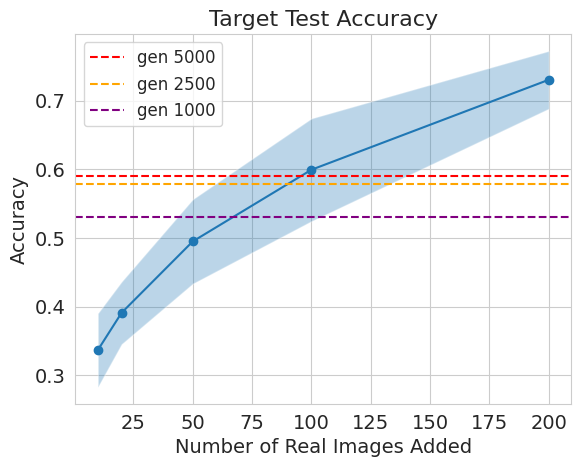

In [60]:
df = df_ablation[df_ablation['metric'] == 'out_acc']
plt.plot(df['num_images'], df['mean'], marker='o',)
# grayscale-to-color
plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'out_acc') & \
            (df_ablation2['num_images'] == 5000)]['mean'].iloc[0], color='red', linestyle='--', label = 'gen 5000')

plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'out_acc') & \
            (df_ablation2['num_images'] == 2500)]['mean'].iloc[0], color='orange', linestyle='--', label = 'gen 2500')

plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'out_acc') & \
            (df_ablation2['num_images'] == 1000)]['mean'].iloc[0], color='purple', linestyle='--', label = 'gen 1000')

# plt.errorbar(x=df["num_images"], y=df["mean"], 
#                 yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none")
plt.fill_between(df["num_images"].astype(float), df["mean_lower_95"], df["mean_upper_95"], alpha=0.3)
plt.title("Target Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Number of Real Images Added", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f"results/waterbirds_out_acc_real.png", dpi=300)
plt.show()

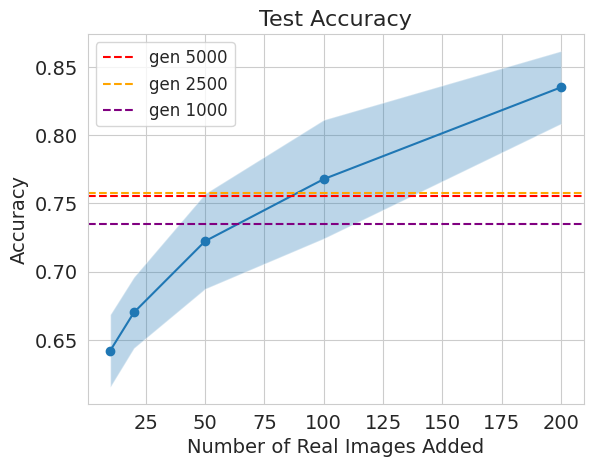

In [61]:
df = df_ablation[df_ablation['metric'] == 'acc']
plt.plot(df['num_images'], df['mean'], marker='o',)
# grayscale-to-color
plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'acc') & \
            (df_ablation2['num_images'] == 5000)]['mean'].iloc[0], color='red', linestyle='--', label = 'gen 5000')

plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'acc') & \
            (df_ablation2['num_images'] == 2500)]['mean'].iloc[0], color='orange', linestyle='--', label = 'gen 2500')

plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'acc') & \
            (df_ablation2['num_images'] == 1000)]['mean'].iloc[0], color='purple', linestyle='--', label = 'gen 1000')

# plt.errorbar(x=df["num_images"], y=df["mean"], 
#                 yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none")
plt.fill_between(df["num_images"].astype(float), df["mean_lower_95"], df["mean_upper_95"], alpha=0.3)
plt.title("Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Number of Real Images Added", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f"results/waterbirds_acc_real.png", dpi=300)
plt.show()

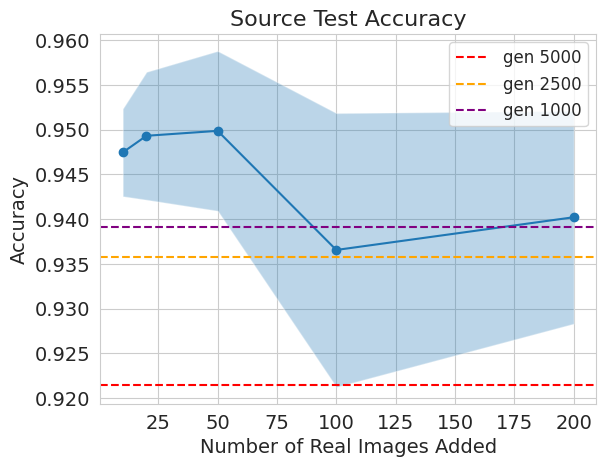

In [62]:
df = df_ablation[df_ablation['metric'] == 'in_acc']
plt.plot(df['num_images'], df['mean'], marker='o',)
# grayscale-to-color
plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'in_acc') & \
            (df_ablation2['num_images'] == 5000)]['mean'].iloc[0], color='red', linestyle='--', label = 'gen 5000')

plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'in_acc') & \
            (df_ablation2['num_images'] == 2500)]['mean'].iloc[0], color='orange', linestyle='--', label = 'gen 2500')

plt.axhline(y=df_ablation2[(df_ablation2['metric'] == 'in_acc') & \
            (df_ablation2['num_images'] == 1000)]['mean'].iloc[0], color='purple', linestyle='--', label = 'gen 1000')

# plt.errorbar(x=df["num_images"], y=df["mean"], 
#                 yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none")
plt.fill_between(df["num_images"].astype(float), df["mean_lower_95"], df["mean_upper_95"], alpha=0.3)
plt.title("Source Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Number of Real Images Added", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f"results/waterbirds_in_acc_real.png", dpi=300)
plt.show()

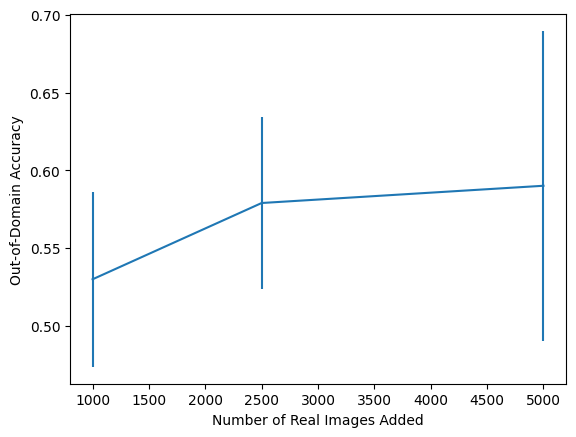

In [82]:
df = df_ablation2[df_ablation2['metric'] == 'out_acc']
plt.plot(df['num_images'], df['mean'])
# grayscale-to-color
# plt.axhline(y=0.456, color='red', linestyle='--')
plt.errorbar(x=df["num_images"], y=df["mean"], 
                yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none")
plt.ylabel("Out-of-Domain Accuracy")
plt.xlabel("Number of Real Images Added")
# plt.savefig(f"results/waterbirds_out_acc_diffusion.png", dpi=300)
plt.show()

# CXR

In [379]:
import scipy.stats as st
# Calculate 95% confidence intervals with Student t's continuous random variable 
def calculate_CI(df, edit_df, names):
    # Iterate through pathologies
    for name in names:
        for p in df.columns: 
            data = df.loc[name, p]
            lower, upper = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
            
            edit_df.loc[name, p + '_lower_95'] = lower
            edit_df.loc[name, p + '_upper_95'] = upper
            edit_df.loc[name, p + '_lower_95_err'] = edit_df.loc[name, p] - lower
            edit_df.loc[name, p + '_upper_95_err'] = upper - edit_df.loc[name, p]
    return edit_df

In [380]:
pathologies = ['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Lesion',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']

## Source MIMIC

In [389]:
# Source MIMIC 
names = ["baseline_results_new3", "cutmix_results_new3", "mixup_results_alpha0.5"]
seeds = [0, 1, 2]
tuples = list(itertools.product(names, seeds))
index = pd.MultiIndex.from_tuples(tuples, names=["model", "seed"])

num_classes = 8

df_aucs = pd.DataFrame(index=index, columns = pathologies)
df_bacc = pd.DataFrame(index=index, columns = pathologies)

for name in names: 
    for seed in seeds: 
        output_dir = f"/mnt/scratch-lids/scratch/qixuanj/cxr_results/{name}/train/logs/{seed}"

        with open(f"{output_dir}/mimic_epoch10_task_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/mimic_epoch10_task_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)

        for i in range(num_classes):
            auc_metric = BinaryAUROC()
            auc_metric.update(torch.Tensor(test_outputs[i]), torch.Tensor(test_targets[i]))
            df_aucs.loc[(name, seed), pathologies[i]] = auc_metric.compute().item()
            
            acc_metric = BinaryAccuracy()
            acc_metric.update(torch.Tensor(test_outputs[i]), torch.Tensor(test_targets[i]))
            df_bacc.loc[(name, seed), pathologies[i]] = acc_metric.compute().item()

In [390]:
df_aucs['Mean'] = df_aucs.mean(axis=1).values
df_bacc['Mean'] = df_bacc.mean(axis=1).values
df_aucs_mean = df_aucs.groupby(level=0).mean()
df_bacc_mean = df_bacc.groupby(level=0).mean()

In [392]:
df_aucs_mean

,Atelectasis,Cardiomegaly,Consolidation,Edema,Lesion,Pneumonia,Pneumothorax,No Finding,Mean
model,,,,,,,,,
baseline_results_new3,0.882767,0.868158,0.910879,0.920563,0.830116,0.816446,0.789192,0.848758,0.85836
cutmix_results_new3,0.780264,0.813524,0.823195,0.853003,0.633567,0.647347,0.725375,0.792413,0.758586
mixup_results_alpha0.5,0.792228,0.842063,0.824519,0.882002,0.62291,0.734368,0.723394,0.801156,0.77783


In [393]:
df_bacc_mean

,Atelectasis,Cardiomegaly,Consolidation,Edema,Lesion,Pneumonia,Pneumothorax,No Finding,Mean
model,,,,,,,,,
baseline_results_new3,0.810583,0.785822,0.891988,0.855114,0.906647,0.839252,0.895873,0.807833,0.849139
cutmix_results_new3,0.622851,0.621418,0.87251,0.743371,0.909091,0.83047,0.89619,0.755333,0.781404
mixup_results_alpha0.5,0.622851,0.621719,0.875166,0.743371,0.909091,0.83047,0.89619,0.766167,0.783128


In [394]:
df_aucs_mean = calculate_CI(df_aucs, df_aucs_mean, names)
df_bacc_mean = calculate_CI(df_bacc, df_bacc_mean, names)

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [395]:
df_aucs_mean

,Atelectasis,Cardiomegaly,Consolidation,Edema,Lesion,Pneumonia,Pneumothorax,No Finding,Mean,Atelectasis_lower_95,...,Pneumothorax_lower_95_err,Pneumothorax_upper_95_err,No Finding_lower_95,No Finding_upper_95,No Finding_lower_95_err,No Finding_upper_95_err,Mean_lower_95,Mean_upper_95,Mean_lower_95_err,Mean_upper_95_err
model,,,,,,,,,,,,,,,,,,,,,
baseline_results_new3,0.882767,0.868158,0.910879,0.920563,0.830116,0.816446,0.789192,0.848758,0.85836,0.865622,...,0.053275,0.053275,0.820878,0.876639,0.027880,0.027880,0.839822,0.876898,0.018538,0.018538
cutmix_results_new3,0.780264,0.813524,0.823195,0.853003,0.633567,0.647347,0.725375,0.792413,0.758586,0.702037,...,0.126573,0.126573,0.761708,0.823117,0.030704,0.030704,0.743807,0.773365,0.014779,0.014779
mixup_results_alpha0.5,0.792228,0.842063,0.824519,0.882002,0.62291,0.734368,0.723394,0.801156,0.77783,0.711239,...,0.153539,0.153539,0.765640,0.836672,0.035516,0.035516,0.721880,0.833780,0.055950,0.055950


/tmp/ipykernel_901384/3451547826.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5",


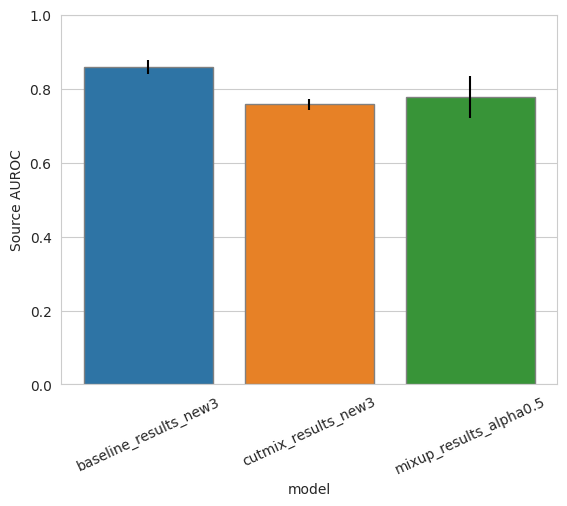

In [399]:
df = df_aucs_mean

ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df.index, y=df["Mean"], 
            yerr = df[['Mean_lower_95_err', 'Mean_upper_95_err']].T, fmt="none", c="k")

plt.ylabel("Source AUROC")
plt.ylim(0., 1.)
plt.xticks(rotation=25)
plt.savefig(f"results/cxr_source_auc.png", dpi=300)
plt.show()

In [400]:
df = df_bacc_mean

/tmp/ipykernel_901384/2453243246.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5",


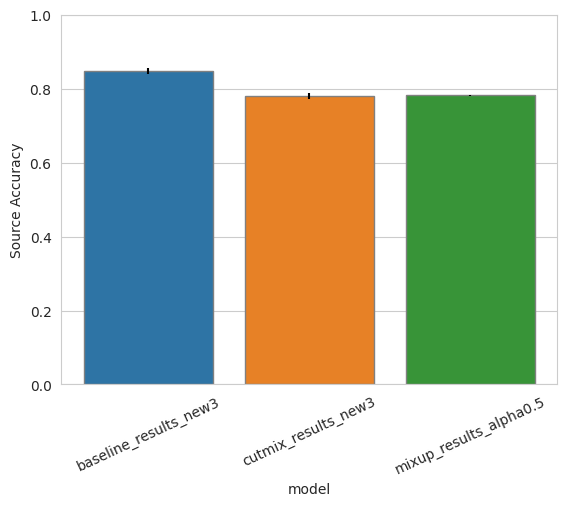

In [401]:
ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
ax.errorbar(x=df.index, y=df["Mean"], 
            yerr = df[['Mean_lower_95_err', 'Mean_upper_95_err']].T, fmt="none", c="k")

plt.ylabel("Source Accuracy")
plt.ylim(0., 1.)
plt.xticks(rotation=25)
plt.savefig(f"results/cxr_source_acc.png", dpi=300)
plt.show()

In [405]:
# # Source model on transfer dataset 
# dataset = "padchest"
# names = ["baseline_results_new3", "cutmix_results_new3", "mixup_results_alpha0.5"]
# seeds = [0, 1, 2]

dataset = "chexpert"
names = ["diffusion0.9_results"]
seeds = [0, 1]


tuples = list(itertools.product(names, seeds))
index = pd.MultiIndex.from_tuples(tuples, names=["model", "seed"])

num_classes = 8

df_aucs = pd.DataFrame(index=index, columns = pathologies)
df_bacc = pd.DataFrame(index=index, columns = pathologies)

for name in names: 
    for seed in seeds: 
        output_dir = f"/mnt/scratch-lids/scratch/qixuanj/cxr_results/{name}/train/logs/{seed}"

        with open(f"{output_dir}/mimic_{dataset}_epoch10_task_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/mimic_{dataset}_epoch10_task_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)

        for i in range(num_classes):
            auc_metric = BinaryAUROC()
            auc_metric.update(torch.Tensor(test_outputs[i]), torch.Tensor(test_targets[i]))
            df_aucs.loc[(name, seed), pathologies[i]] = auc_metric.compute().item()
            
            acc_metric = BinaryAccuracy()
            acc_metric.update(torch.Tensor(test_outputs[i]), torch.Tensor(test_targets[i]))
            df_bacc.loc[(name, seed), pathologies[i]] = acc_metric.compute().item()

In [406]:
df_aucs['Mean'] = df_aucs.mean(axis=1).values
df_bacc['Mean'] = df_bacc.mean(axis=1).values
df_aucs_mean = df_aucs.groupby(level=0).mean()
df_bacc_mean = df_bacc.groupby(level=0).mean()

In [407]:
df_aucs_mean = calculate_CI(df_aucs, df_aucs_mean, names)
df_bacc_mean = calculate_CI(df_bacc, df_bacc_mean, names)

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [408]:
df_aucs_mean[['Mean', 'Mean_lower_95', 'Mean_upper_95']]

,Mean,Mean_lower_95,Mean_upper_95
model,,,
diffusion0.9_results,0.755557,0.663877,0.847236


In [395]:
# Transfer MIMIC 
# names = ["baseline_results_new3", "cutmix_results_new3", "mixup_results_alpha0.5", "diffusion0.9_results"]
# seeds = [0, 1, 2]
# datasets = ["chexpert", "nih", "padchest"]
# tuples = list(itertools.product(names, datasets, seeds))
# index = pd.MultiIndex.from_tuples(tuples, names=["model", "dataset", "seed"])

# num_classes = 8

# df_aucs = pd.DataFrame(index=index, columns = pathologies)
# df_bacc = pd.DataFrame(index=index, columns = pathologies)

# for name in names:
#     for dataset in datasets: 
#         for seed in seeds: 
#             output_dir = f"/mnt/scratch-lids/scratch/qixuanj/cxr_results/{name}/transfer/logs/1000/{seed}"

#             if not os.path.exists(f"{output_dir}/mimic_{dataset}_match_epoch10_task_outputs.pkl"): 
#                 continue
#             with open(f"{output_dir}/mimic_{dataset}_match_epoch10_task_outputs.pkl", "rb") as f: 
#                 test_outputs = pickle.load(f)
#             with open(f"{output_dir}/mimic_{dataset}_match_epoch10_task_targets.pkl", "rb") as f: 
#                 test_targets = pickle.load(f)
    
#             for i in range(num_classes):
#                 auc_metric = BinaryAUROC()
#                 auc_metric.update(torch.Tensor(test_outputs[i]), torch.Tensor(test_targets[i]))
#                 df_aucs.loc[(name, dataset, seed), pathologies[i]] = auc_metric.compute().item()
                
#                 acc_metric = BinaryAccuracy()
#                 acc_metric.update(torch.Tensor(test_outputs[i]), torch.Tensor(test_targets[i]))
#                 df_bacc.loc[(name, dataset, seed), pathologies[i]] = acc_metric.compute().item()

In [403]:
df_aucs['Mean'] = df_aucs.mean(axis=1).values
df_bacc['Mean'] = df_bacc.mean(axis=1).values

In [408]:
df_aucs_mean = df_aucs.groupby(level=[0, 1]).mean()
df_bacc_mean = df_bacc.groupby(level=[0, 1]).mean()

In [409]:
df_aucs_mean = calculate_CI(df_aucs, df_aucs_mean, names)
df_bacc_mean = calculate_CI(df_bacc, df_bacc_mean, names)

/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = df.loc[name, p]
/tmp/ipykernel_901384/2140529208.py:7: Performan

In [416]:
df_aucs_mean

Atelectasis Cardiomegaly Consolidation  \
model                  dataset                                           
baseline_results_new3  chexpert    0.861932     0.883345      0.878202   
                       nih         0.633638     0.805528      0.700508   
                       padchest    0.663418     0.862733      0.732684   
cutmix_results_new3    chexpert    0.668821     0.810661      0.844914   
                       nih         0.651955     0.744097      0.621207   
                       padchest    0.647641     0.838174      0.754414   
diffusion0.9_results   chexpert    0.845642      0.86445      0.850633   
                       nih         0.676205     0.837354      0.686309   
                       padchest    0.669524     0.874677       0.76609   
mixup_results_alpha0.5 chexpert    0.736176     0.843031      0.815755   
                       nih          0.64695     0.818453      0.623012   
                       padchest    0.665929     0.858609      0.845474   

                                    Edema    Lesion Pneumonia Pneumothorax  \
model                  dataset                                               
baseline_results_new3  chexpert   0.87415  0.711769   0.77803     0.728202   
                       nih       0.778266  0.625793  0.686179     0.662228   
                       padchest  0.997499  0.595829  0.750091     0.888199   
cutmix_results_new3    chexpert  0.887251  0.537403  0.648981     0.620303   
                       nih       0.817067  0.554848  0.669302     0.628791   
                       padchest  0.997332  0.579486  0.740789     0.824653   
diffusion0.9_results   chexpert  0.884447  0.670161  0.760972      0.72472   
                       nih       0.764525  0.642983  0.665254      0.64381   
                       padchest  0.998332  0.578834  0.722366      0.82413   
mixup_results_alpha0.5 chexpert  0.864055  0.537749  0.704023     0.652281   
                       nih       0.820259  0.544304  0.625661        0.643   
                       padchest  0.995498  0.558918  0.669235      0.78491   

                                No Finding      Mean  Atelectasis_lower_95  \
model                  dataset                                               
baseline_results_new3  chexpert   0.810239  0.815734              0.636664   
                       nih        0.683118  0.696907              0.636664   
                       padchest   0.724887  0.776917              0.636664   
cutmix_results_new3    chexpert   0.797544  0.726985              0.633313   
                       nih        0.645664  0.666617              0.633313   
                       padchest   0.684834  0.758415              0.633313   
diffusion0.9_results   chexpert   0.789148  0.798772                   NaN   
                       nih        0.695661  0.701512                   NaN   
                       padchest   0.716678  0.768829                   NaN   
mixup_results_alpha0.5 chexpert   0.803494  0.744571              0.647062   
                       nih        0.641724   0.67042              0.647062   
                       padchest   0.708156  0.760841              0.647062   

                                 ...  Pneumothorax_lower_95_err  \
model                  dataset   ...                              
baseline_results_new3  chexpert  ...                        NaN   
                       nih       ...                        NaN   
                       padchest  ...                        NaN   
cutmix_results_new3    chexpert  ...                        NaN   
                       nih       ...                        NaN   
                       padchest  ...                        NaN   
diffusion0.9_results   chexpert  ...                        NaN   
                       nih       ...                        NaN   
                       padchest  ...                        NaN   
mixup_results_alpha0.5 chexpert  ...                        NaN   
     

/tmp/ipykernel_901384/2727856721.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


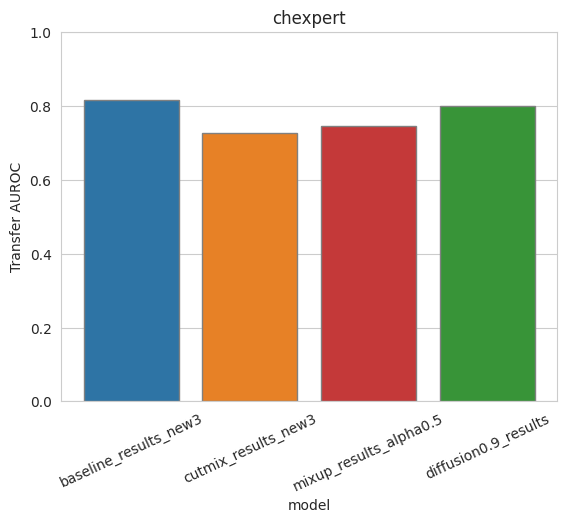

/tmp/ipykernel_901384/2727856721.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


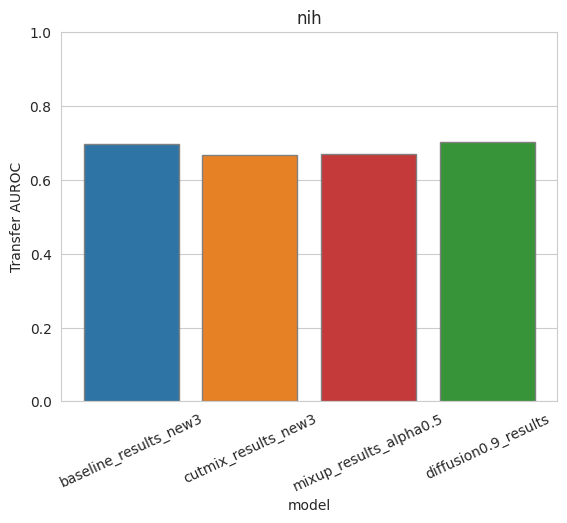

/tmp/ipykernel_901384/2727856721.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


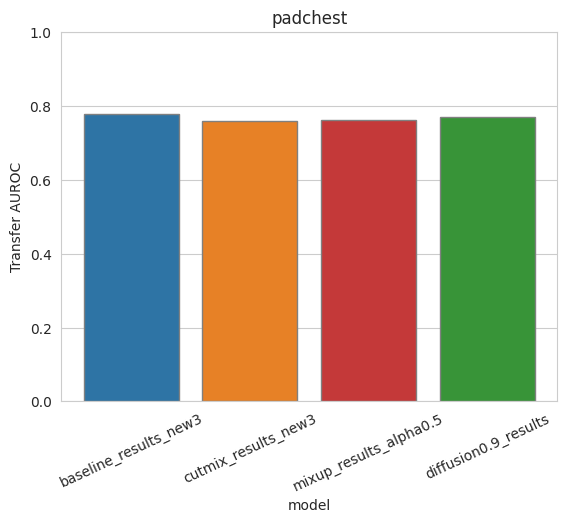

In [419]:
datasets = ["chexpert", "nih", "padchest"]
for dataset in datasets:
    df = df_aucs_mean.xs(dataset, level=1)
    ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
                     palette=sns.color_palette("tab10"), 
                     saturation=.8,
                     alpha=1.)
    ax.errorbar(x=df.index, y=df["Mean"], 
                yerr = df[['Mean_lower_95_err', 'Mean_upper_95_err']].T, fmt="none", c="k")
    
    plt.ylabel("Transfer AUROC")
    plt.title(dataset)
    plt.ylim(0., 1.)
    plt.xticks(rotation=25)
    plt.savefig(f"results/cxr_transfer_{dataset}_auc.png", dpi=300)
    plt.show()

/tmp/ipykernel_901384/2268831792.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


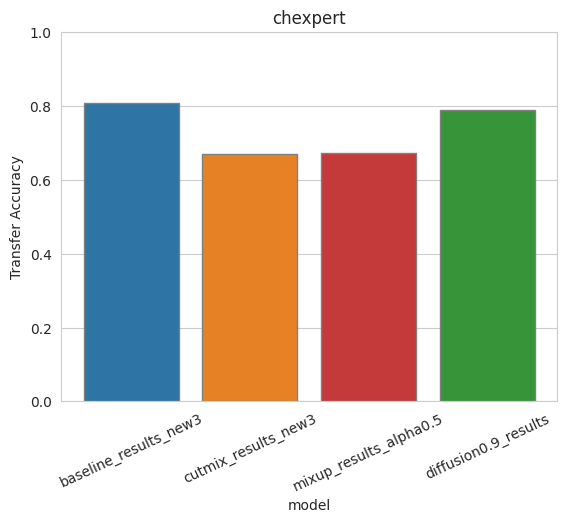

/tmp/ipykernel_901384/2268831792.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


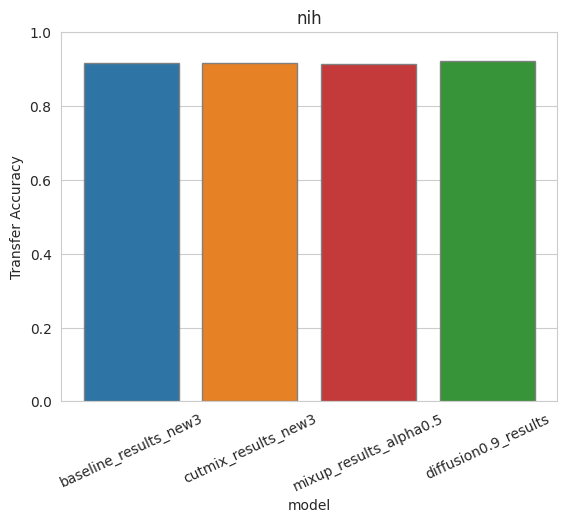

/tmp/ipykernel_901384/2268831792.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


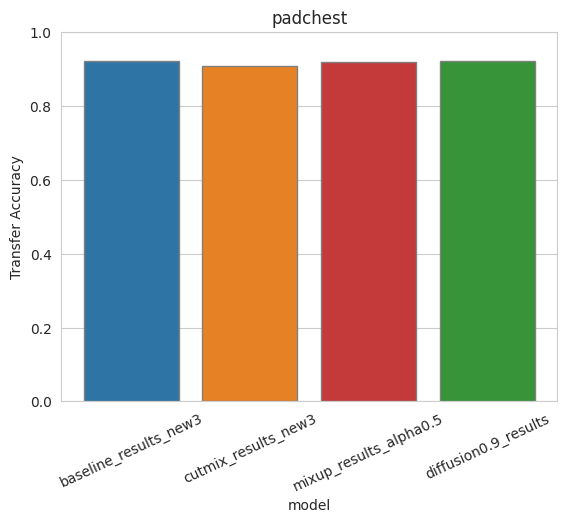

In [420]:
datasets = ["chexpert", "nih", "padchest"]
for dataset in datasets:
    df = df_bacc_mean.xs(dataset, level=1)
    ax = sns.barplot(df,x=df.index, y="Mean", hue=df.index, edgecolor=".5", order = names,
                     palette=sns.color_palette("tab10"), 
                     saturation=.8,
                     alpha=1.)
    ax.errorbar(x=df.index, y=df["Mean"], 
                yerr = df[['Mean_lower_95_err', 'Mean_upper_95_err']].T, fmt="none", c="k")
    
    plt.ylabel("Transfer Accuracy")
    plt.title(dataset)
    plt.ylim(0., 1.)
    plt.xticks(rotation=25)
    plt.savefig(f"results/cxr_transfer_{dataset}_acc.png", dpi=300)
    plt.show()

# ISIC 

In [138]:
import scipy.stats as st
# Calculate 95% confidence intervals with Student t's continuous random variable 
def calculate_CI(df, names, seeds):
    df['lower_95'] = 0
    df['upper_95'] = 0
    df['lower_95_err'] = 0
    df['upper_95_err'] = 0
    for name in names: 
        if name == "oracle": 
            df.loc[name, 'lower_95'] = df.loc[name, 'mean']
            df.loc[name, 'upper_95'] = df.loc[name, 'mean']
            df.loc[name, 'lower_95_err'] = 0
            df.loc[name, 'upper_95_err'] = 0
        else:
            data = df.loc[name, seeds].dropna()
            lower, upper = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
            df.loc[name, 'lower_95'] = lower
            df.loc[name, 'upper_95'] = upper
            df.loc[name, 'lower_95_err'] = df.loc[name, 'mean'] - lower
            df.loc[name, 'upper_95_err'] = upper - df.loc[name, 'mean']
    return df

In [651]:
# with open("/mnt/scratch-lids/scratch/qixuanj/isic_results_densenet121_no_patches/oracle_seed1/test_aucs.pkl", "rb") as f: 
#     tmp = pickle.load(f)

In [97]:
from isic_dataset import SpuriousDermDataset
filepath = "/data/scratch/wgerych/spurious_ISIC_ruler_no_patches/"

test_dataset = SpuriousDermDataset(file_path=filepath, split='test')

In [98]:
# 0: malignant with marking 1: malignant without marking 2: benign with marking 3: benign without marking 
groups = test_dataset.metadata_for_split['class']

indomain = (groups == 0) | (groups == 3)
outdomain = (groups == 1) | (groups == 2)

In [139]:
# Source ISIC
# res_dir = "/mnt/scratch-lids/scratch/qixuanj/isic_results_densenet121_no_patches"
res_dir = "/mnt/scratch-lids/scratch/qixuanj/isic_results_resnet50_no_patches"

# names = ["base", "cutmix", "mixup", "strength0.5"]
# seeds = [0, 1, 2, 3, 5, 6, 7]

# names = ["oracle"] 
# seeds = [0]

names = ["text2img", "img2img_0.5", "strength0.5"]
seeds = [0, 1, 2, 3, 4, 5]

df_aucs = pd.DataFrame(index=names, columns = seeds)
df_in_auc = pd.DataFrame(index=names, columns = seeds)
df_out_auc = pd.DataFrame(index=names, columns = seeds)

df_bacc = pd.DataFrame(index=names, columns = seeds)
df_in_acc = pd.DataFrame(index=names, columns = seeds)
df_out_acc = pd.DataFrame(index=names, columns = seeds)

for name in names: 
    for seed in seeds: 
        if 'gen' in name or 'source' in name or 'strength' in name or 'img' in name: 
            output_dir = f"{res_dir}/diffusion_seed{seed}/{name}"
        else:
            output_dir = f"{res_dir}/{name}_seed{seed}"
        
        if not os.path.exists(f"{output_dir}/test_outputs.pkl"): 
            continue
        with open(f"{output_dir}/test_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/test_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)
        
        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_aucs.loc[name, seed] = auc_metric.compute().item()

        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_auc.loc[name, seed] = auc_metric.compute().item()
        
        auc_metric = BinaryAUROC()
        auc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_auc.loc[name, seed] = auc_metric.compute().item()

        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_bacc.loc[name, seed] = acc_metric.compute().item()
        
        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_acc.loc[name, seed] = acc_metric.compute().item()
        
        acc_metric = BinaryAccuracy()
        acc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_acc.loc[name, seed] = acc_metric.compute().item()

In [140]:
df_aucs['mean'] = df_aucs.mean(axis=1)
df_aucs['std'] = df_aucs.std(axis=1)
df_in_auc['mean'] = df_in_auc.mean(axis=1)
df_in_auc['std'] = df_in_auc.std(axis=1)
df_out_auc['mean'] = df_out_auc.mean(axis=1)
df_out_auc['std'] = df_out_auc.std(axis=1)

df_bacc['mean'] = df_bacc.mean(axis=1)
df_bacc['std'] = df_bacc.std(axis=1)
df_in_acc['mean'] = df_in_acc.mean(axis=1)
df_in_acc['std'] = df_in_acc.std(axis=1)
df_out_acc['mean'] = df_out_acc.mean(axis=1)
df_out_acc['std'] = df_out_acc.std(axis=1)

In [141]:
df_aucs = calculate_CI(df_aucs, names, seeds)
df_in_auc = calculate_CI(df_in_auc, names, seeds)
df_out_auc = calculate_CI(df_out_auc, names, seeds)

df_bacc = calculate_CI(df_bacc, names, seeds)
df_in_acc = calculate_CI(df_in_acc, names, seeds)
df_out_acc = calculate_CI(df_out_acc, names, seeds)

In [275]:
df_aucs.index = ["Base", "CutMix", "MixUp", "MaskMedPaint"]
df_in_auc.index = ["Base", "CutMix", "MixUp", "MaskMedPaint"]
df_out_auc.index = ["Base", "CutMix", "MixUp", "MaskMedPaint"]

df_bacc.index = ["Base", "CutMix", "MixUp", "MaskMedPaint"]
df_in_acc.index = ["Base", "CutMix", "MixUp", "MaskMedPaint"]
df_out_acc.index = ["Base", "CutMix", "MixUp", "MaskMedPaint"]

In [142]:
df_aucs.index = ["Text2Img", "Img2Img", "MaskMedPaint"]
df_in_auc.index = ["Text2Img", "Img2Img", "MaskMedPaint"]
df_out_auc.index = ["Text2Img", "Img2Img", "MaskMedPaint"]

df_bacc.index = ["Text2Img", "Img2Img", "MaskMedPaint"]
df_in_acc.index = ["Text2Img", "Img2Img", "MaskMedPaint"]
df_out_acc.index = ["Text2Img", "Img2Img", "MaskMedPaint"]

In [143]:
df_bacc

,0,1,2,3,4,5,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
Text2Img,0.528571,0.546429,0.560714,0.546429,0.532143,NaN,0.542857,0.011518,0.526868,0.558846,0.015989,0.015989
Img2Img,0.539286,0.510714,0.525,0.532143,0.532143,NaN,0.527857,0.009689,0.514407,0.541308,0.013451,0.013451
MaskMedPaint,0.521429,0.539286,0.546429,0.585714,NaN,0.546429,0.547857,0.02102,0.518677,0.577037,0.029180,0.029180


In [144]:
df_in_acc

,0,1,2,3,4,5,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
Text2Img,0.935714,0.942857,0.95,0.907143,0.907143,NaN,0.928571,0.01807,0.903486,0.953657,0.025085,0.025085
Img2Img,0.928571,0.9,0.885714,0.928571,0.928571,NaN,0.914286,0.01807,0.889200,0.939371,0.025085,0.025085
MaskMedPaint,0.65,0.728571,0.714286,0.792857,NaN,0.785714,0.734286,0.052177,0.661852,0.806719,0.072433,0.072433


In [145]:
df_out_acc

,0,1,2,3,4,5,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
Text2Img,0.121429,0.15,0.171429,0.185714,0.157143,NaN,0.157143,0.021665,0.127067,0.187219,0.030076,0.030076
Img2Img,0.15,0.121429,0.164286,0.135714,0.135714,NaN,0.141429,0.014569,0.121204,0.161653,0.020224,0.020224
MaskMedPaint,0.392857,0.35,0.378571,0.378571,NaN,0.307143,0.361429,0.030506,0.319080,0.403778,0.042349,0.042349


In [146]:
df_aucs.to_csv(f"results/isic_aucs_ablation.csv")
df_in_auc.to_csv(f"results/isic_in_aucs_ablation.csv")
df_out_auc.to_csv(f"results/isic_out_aucs_ablation.csv")

df_bacc.to_csv(f"results/isic_baccs_ablation.csv")
df_in_acc.to_csv(f"results/isic_in_accs_ablation.csv")
df_out_acc.to_csv(f"results/isic_out_accs_ablation.csv")

In [279]:
df_aucs.to_csv(f"{res_dir}/source_aucs.csv")
df_in_auc.to_csv(f"{res_dir}/source_in_aucs.csv")
df_out_auc.to_csv(f"{res_dir}/source_out_aucs.csv")

df_bacc.to_csv(f"{res_dir}/source_baccs.csv")
df_in_acc.to_csv(f"{res_dir}/source_in_accs.csv")
df_out_acc.to_csv(f"{res_dir}/source_out_accs.csv")

In [329]:
df_aucs.to_csv(f"results/isic_aucs.csv")
df_in_auc.to_csv(f"results/isic_in_aucs.csv")
df_out_auc.to_csv(f"results/isic_out_aucs.csv")

df_bacc.to_csv(f"results/isic_baccs.csv")
df_in_acc.to_csv(f"results/isic_in_accs.csv")
df_out_acc.to_csv(f"results/isic_out_accs.csv")

In [16]:
# Transfer
# names = ["base",]
# seeds = [0, 1,]

# df_aucs = pd.DataFrame(index=names, columns = seeds)
# df_bacc = pd.DataFrame(index=names, columns = seeds)
# df_in_acc = pd.DataFrame(index=names, columns = seeds)
# df_out_acc = pd.DataFrame(index=names, columns = seeds)

# for name in names: 
#     for seed in seeds: 
#         output_dir = f"{res_dir}/{name}_seed{seed}/transfer"

#         with open(f"{output_dir}/test_outputs.pkl", "rb") as f: 
#             test_outputs = pickle.load(f)
#         with open(f"{output_dir}/test_targets.pkl", "rb") as f: 
#             test_targets = pickle.load(f)

#         auc_metric = BinaryAUROC()
#         auc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
#         df_aucs.loc[name, seed] = auc_metric.compute().item()

#         acc_metric = BinaryAccuracy()
#         acc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
#         df_bacc.loc[name, seed] = acc_metric.compute().item()
        
#         acc_metric = BinaryAccuracy()
#         acc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
#         df_in_acc.loc[name, seed] = acc_metric.compute().item()
        
#         acc_metric = BinaryAccuracy()
#         acc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
#         df_out_acc.loc[name, seed] = acc_metric.compute().item()

In [17]:
# df_aucs['mean'] = df_aucs.mean(axis=1)
# df_aucs['std'] = df_aucs.std(axis=1)
# df_bacc['mean'] = df_bacc.mean(axis=1)
# df_bacc['std'] = df_bacc.std(axis=1)
# df_in_acc['mean'] = df_in_acc.mean(axis=1)
# df_in_acc['std'] = df_bacc.std(axis=1)
# df_out_acc['mean'] = df_out_acc.mean(axis=1)
# df_out_acc['std'] = df_bacc.std(axis=1)

In [68]:
res_dir = "/mnt/scratch-lids/scratch/qixuanj/isic_results_resnet50_no_patches"
df_aucs = pd.read_csv(f"{res_dir}/source_aucs.csv", index_col=0)
df_in_auc = pd.read_csv(f"{res_dir}/source_in_aucs.csv", index_col=0)
df_out_auc = pd.read_csv(f"{res_dir}/source_out_aucs.csv", index_col=0)

df_bacc = pd.read_csv(f"{res_dir}/source_baccs.csv", index_col=0)
df_in_acc = pd.read_csv(f"{res_dir}/source_in_accs.csv", index_col=0)
df_out_acc = pd.read_csv(f"{res_dir}/source_out_accs.csv", index_col=0)

In [134]:
sns.set_style("whitegrid")

In [135]:
oracle = False
ablation = True

In [148]:
df_bacc

,0,1,2,3,4,5,mean,std,lower_95,upper_95,lower_95_err,upper_95_err
Text2Img,0.528571,0.546429,0.560714,0.546429,0.532143,NaN,0.542857,0.011518,0.526868,0.558846,0.015989,0.015989
Img2Img,0.539286,0.510714,0.525,0.532143,0.532143,NaN,0.527857,0.009689,0.514407,0.541308,0.013451,0.013451
MaskMedPaint,0.521429,0.539286,0.546429,0.585714,NaN,0.546429,0.547857,0.02102,0.518677,0.577037,0.029180,0.029180


/tmp/ipykernel_1848278/2342122011.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df_bacc,x=df_bacc.index, y="mean", hue=df_bacc.index, edgecolor=".5",


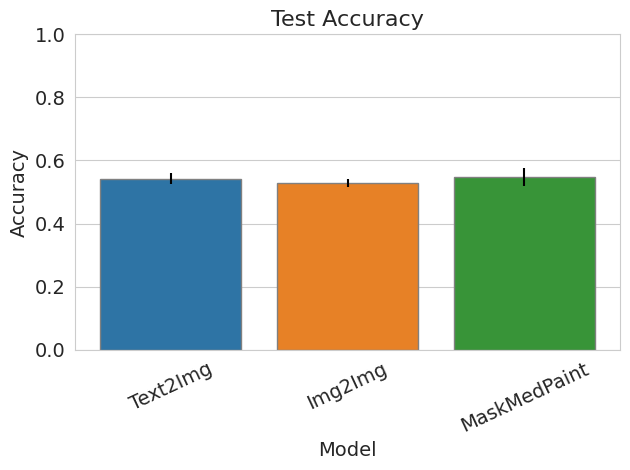

In [149]:
ax = sns.barplot(df_bacc,x=df_bacc.index, y="mean", hue=df_bacc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
if oracle:
    ax.axhline(y=0.685, color='gray', linestyle='--')
ax.errorbar(x=df_bacc.index, y=df_bacc["mean"], yerr = df_bacc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if oracle:
    plt.savefig("results/isic_acc_oracle.png", dpi=300)
elif ablation: 
    plt.savefig("results/isic_acc_ablation", dpi=300)
else:
    plt.savefig("results/isic_acc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/3516180071.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df_in_acc,x=df_in_acc.index, y="mean", hue=df_in_acc.index, edgecolor=".5",


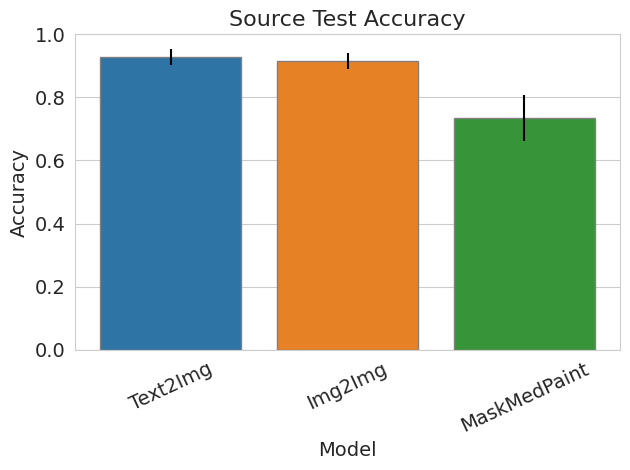

In [150]:
ax = sns.barplot(df_in_acc,x=df_in_acc.index, y="mean", hue=df_in_acc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
if oracle:
    ax.axhline(y=0.628, color='gray', linestyle='--')
ax.errorbar(x=df_in_acc.index, y=df_in_acc["mean"], yerr = df_in_acc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Source Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if oracle:
    plt.savefig("results/isic_in_acc_oracle.png", dpi=300)
elif ablation: 
    plt.savefig("results/isic_in_acc_ablation", dpi=300)
else: 
    plt.savefig("results/isic_in_acc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/2355626067.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df_out_acc,x=df_out_acc.index, y="mean", hue=df_out_acc.index, edgecolor=".5",


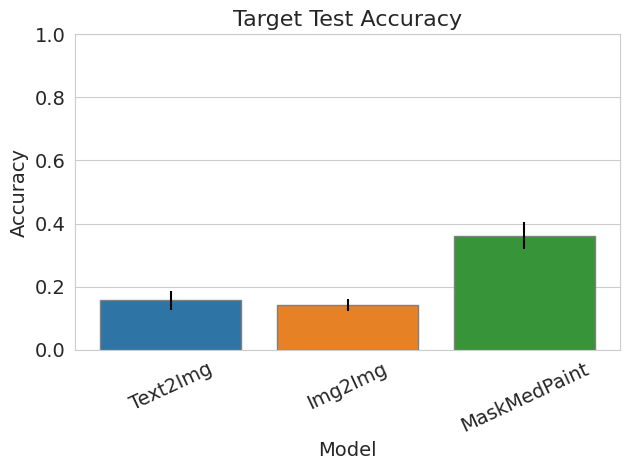

In [151]:
ax = sns.barplot(df_out_acc,x=df_out_acc.index, y="mean", hue=df_out_acc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
if oracle:
    ax.axhline(y=0.742, color='gray', linestyle='--')
ax.errorbar(x=df_out_acc.index, y=df_out_acc["mean"], yerr = df_out_acc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Target Test Accuracy", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if oracle: 
    plt.savefig("results/isic_out_acc_oracle.png", dpi=300)
elif ablation: 
    plt.savefig("results/isic_out_acc_ablation", dpi=300)
else: 
    plt.savefig("results/isic_out_acc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/4136316670.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df_aucs,x=df_aucs.index, y="mean", hue=df_aucs.index, edgecolor=".5",


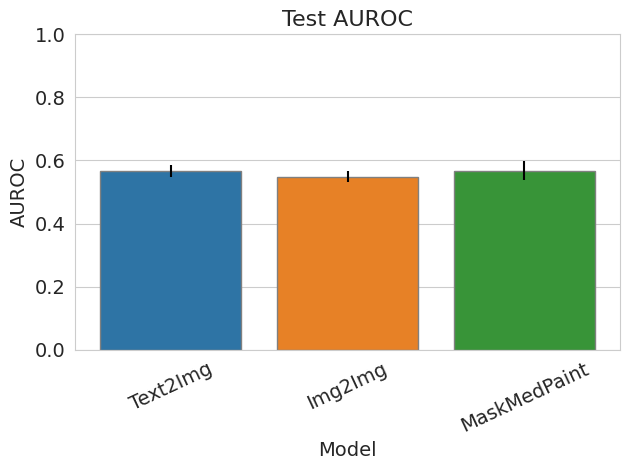

In [152]:
ax = sns.barplot(df_aucs,x=df_aucs.index, y="mean", hue=df_aucs.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
if oracle:
    ax.axhline(y=0.769, color='gray', linestyle='--')
ax.errorbar(x=df_aucs.index, y=df_aucs["mean"], yerr = df_aucs[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Test AUROC", fontsize=16)
plt.ylabel("AUROC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if oracle:
    plt.savefig("results/isic_auc_oracle.png", dpi=300)
elif ablation: 
    plt.savefig("results/isic_auc_ablation", dpi=300)
else: 
    plt.savefig("results/isic_auc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/575416264.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df_in_auc,x=df_in_auc.index, y="mean", hue=df_in_auc.index, edgecolor=".5",


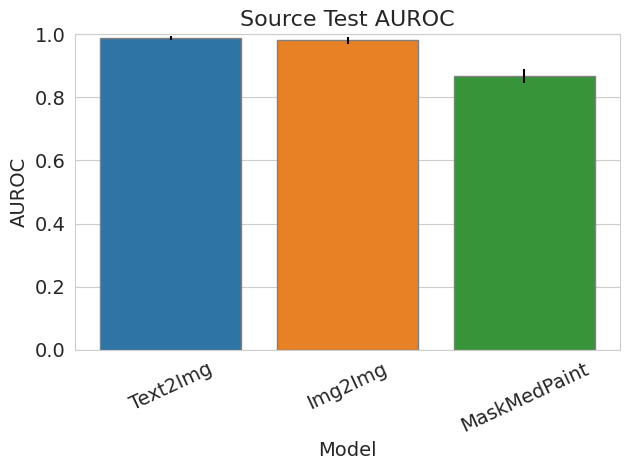

In [153]:
ax = sns.barplot(df_in_auc,x=df_in_auc.index, y="mean", hue=df_in_auc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
if oracle:
    ax.axhline(y=0.726, color='gray', linestyle='--')
ax.errorbar(x=df_in_auc.index, y=df_in_auc["mean"], yerr = df_in_auc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Source Test AUROC", fontsize=16)
plt.ylabel("AUROC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if oracle:
    plt.savefig("results/isic_in_auc_oracle.png", dpi=300)
elif ablation: 
    plt.savefig("results/isic_in_auc_ablation", dpi=300)
else: 
    plt.savefig("results/isic_in_auc.png", dpi=300)
plt.show()

/tmp/ipykernel_1848278/3206635879.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(df_out_auc,x=df_out_auc.index, y="mean", hue=df_out_auc.index, edgecolor=".5",


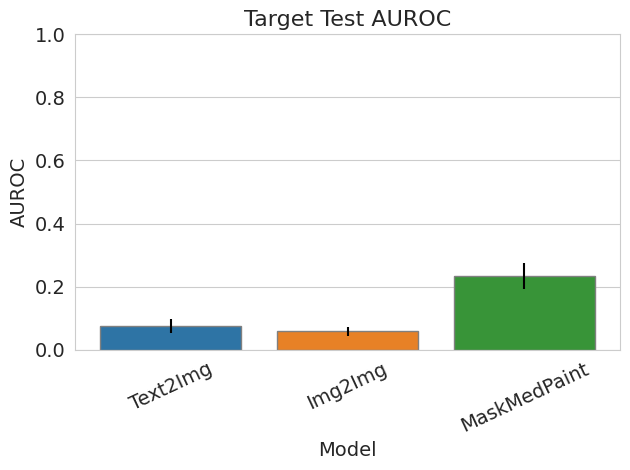

In [154]:
ax = sns.barplot(df_out_auc,x=df_out_auc.index, y="mean", hue=df_out_auc.index, edgecolor=".5",
                 palette=sns.color_palette("tab10"), 
                 saturation=.8,
                 alpha=1.)
if oracle:
    ax.axhline(y=0.823, color='gray', linestyle='--')
ax.errorbar(x=df_out_auc.index, y=df_out_auc["mean"], yerr = df_out_auc[['lower_95_err', 'upper_95_err']].T, fmt="none", c="k")
plt.title("Target Test AUROC", fontsize=16)
plt.ylabel("AUROC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0., 1.)
plt.xticks(rotation=25, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if oracle:
    plt.savefig("results/isic_out_auc_oracle.png", dpi=300)
elif ablation: 
    plt.savefig("results/isic_out_auc_ablation", dpi=300)
else:
    plt.savefig("results/isic_out_auc.png", dpi=300)
plt.show()

# iWildCam

In [80]:
import scipy.stats as st
# Calculate 95% confidence intervals with Student t's continuous random variable 
def calculate_CI(df, edit_df, names, columns):
    # Iterate through pathologies
    for name in names:
        for p in columns: 
            data = df.loc[name, p].dropna()
            if len(data) == 0: 
                continue
            lower, upper = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
            
            edit_df.loc[name, p + '_lower_95'] = lower
            edit_df.loc[name, p + '_upper_95'] = upper
            edit_df.loc[name, p + '_lower_95_err'] = edit_df.loc[name, p] - lower
            edit_df.loc[name, p + '_upper_95_err'] = upper - edit_df.loc[name, p]
    return edit_df

In [91]:
# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), st.sem(a)
#     h = se * st.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

In [79]:
from iwildcam_dataset import iWildCamDataset

In [95]:
# Best 0.9
# shift = 'grayscale-to-color'
# Best 1.0
shift = 'grayscale_night-to-day'

# Ablation
names = ["base"] 
seeds = [0, 1, 2, 3] 
res_dir = "/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v3"
test_dataset = iWildCamDataset(file_path="/mnt/scratch-lids/scratch/qixuanj/iwildcam_subset_organized", 
                                shift = shift, 
                                split = "test",)


# names = ["base", "cutmix", "mixup"] 
# seeds = [0, 1, 2, 3, 4, 5, 6, 7] 
# res_dir = "/mnt/scratch-lids/scratch/qixuanj/iwildcam_results"
# test_dataset = iWildCamDataset(file_path="/mnt/scratch-lids/scratch/qixuanj/iwildcam_subset_organized", 
#                                 shift = shift, 
#                                 split = "test",)

# names = [
#         "diffusion_1.0", 
#         ]
# seeds = [0, 1, 2, 3, 4, 5, 6, 7
#         ]
# res_dir = "/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_copy2"
# test_dataset = iWildCamDataset(file_path="/mnt/scratch-lids/scratch/qixuanj/iwildcam_subset_organized", 
#                                 shift = shift, 
#                                 split = "test",
#                                 version="copy2")

In [427]:
class_names = ['background', 'cattle', 'elephants', 'impalas', 'zebras', 'giraffes', 'dik-diks']
class_names_mod = ['cattle', 'elephants', 'impalas', 'zebras', 'giraffes', 'dik-diks']
print(class_names)

['background', 'cattle', 'elephants', 'impalas', 'zebras', 'giraffes', 'dik-diks']


In [428]:
groups = test_dataset.metadata_for_split[['color', 'time']]

if shift == 'color_day-to-night' or shift == 'grayscale_day-to-night': 
    indomain = (groups['time'] != 'night')
    outdomain = (groups['time'] == 'night')
elif shift == 'color_night-to-day' or shift == 'grayscale_night-to-day': 
    outdomain = (groups['time'] != 'night')
    indomain = (groups['time'] == 'night')
elif shift == 'color-to-grayscale': 
    indomain = (groups['color'] == 'color')
    outdomain = (groups['color'] == 'grayscale') 
elif shift == 'grayscale-to-color': 
    indomain = (groups['color'] == 'grayscale')
    outdomain = (groups['color'] == 'color') 

In [342]:
# Source results 
tuples = list(itertools.product(names, seeds))
index = pd.MultiIndex.from_tuples(tuples, names=["model", "seed"])

df_aucs = pd.DataFrame(index=index, columns =class_names)
df_in_auc = pd.DataFrame(index=index, columns =class_names)
df_out_auc = pd.DataFrame(index=index, columns =class_names)

df_bacc = pd.DataFrame(index=index, columns =class_names)
df_in_acc = pd.DataFrame(index=index, columns =class_names)
df_out_acc = pd.DataFrame(index=index, columns =class_names)

for name in names: 
    for seed in seeds: 
        if "branches" in name: 
            output_dir = f"{res_dir}/{shift}/diffusion_seed{seed}/{name}"
        elif "strength" in name: 
            output_dir = f"{res_dir}/{shift}/base_seed{seed}/{name}"
        elif "diffusion" in name: 
            if "filter" in name: 
                output_dir = f"{res_dir}/{shift}/diffusion_seed{seed}/strength{name.split('_')[1]}_{name.split('_')[2]}"
            else: 
                output_dir = f"{res_dir}/{shift}/diffusion_seed{seed}/strength{name.split('_')[1]}"
        elif "combine" in name: 
            output_dir = f"{res_dir}/{shift}/diffusion_seed{seed}/{name.split('_')[-1]}"
        else:
            output_dir = f"{res_dir}/{shift}/{name}_seed{seed}"

        if not os.path.exists(f"{output_dir}/test_outputs.pkl"): 
            continue
        with open(f"{output_dir}/test_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/test_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)

        test_outputs = torch.sigmoid(torch.Tensor(test_outputs)).numpy()
        
        auc_metric = MulticlassAUROC(num_classes=7, average=None)
        auc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_aucs.loc[(name, seed), :] = auc_metric.compute().numpy()

        auc_metric = MulticlassAUROC(num_classes=7, average=None)
        auc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_auc.loc[(name, seed), :] = auc_metric.compute().numpy()
        
        auc_metric = MulticlassAUROC(num_classes=7, average=None)
        auc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_auc.loc[(name, seed), :] = auc_metric.compute().numpy()

        acc_metric = MulticlassAccuracy(num_classes=7, average=None)
        acc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets).long())
        df_bacc.loc[(name, seed), :] = acc_metric.compute().numpy()
        
        acc_metric = MulticlassAccuracy(num_classes=7, average=None)
        acc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]).long())
        df_in_acc.loc[(name, seed), :] = acc_metric.compute().numpy()
        
        acc_metric = MulticlassAccuracy(num_classes=7, average=None)
        acc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]).long())
        df_out_acc.loc[(name, seed), :] = acc_metric.compute().numpy()

In [343]:
df_aucs = df_aucs.drop(columns=['background'])
df_in_auc = df_in_auc.drop(columns=['background'])
df_out_auc = df_out_auc.drop(columns=['background'])

df_bacc = df_bacc.drop(columns=['background'])
df_in_acc = df_in_acc.drop(columns=['background'])
df_out_acc = df_out_acc.drop(columns=['background'])

In [344]:
df_aucs['mean'] = df_aucs.mean(axis=1)
df_aucs['std'] = df_aucs.std(axis=1)
df_in_auc['mean'] = df_in_auc.mean(axis=1)
df_in_auc['std'] = df_in_auc.std(axis=1)
df_out_auc['mean'] = df_out_acc.mean(axis=1)
df_out_auc['std'] = df_out_acc.std(axis=1)

df_bacc['mean'] = df_bacc.mean(axis=1)
df_bacc['std'] = df_bacc.std(axis=1)
df_in_acc['mean'] = df_in_acc.mean(axis=1)
df_in_acc['std'] = df_in_acc.std(axis=1)
df_out_acc['mean'] = df_out_acc.mean(axis=1)
df_out_acc['std'] = df_out_acc.std(axis=1)

In [345]:
df_aucs_mean = df_aucs.groupby(level=0).mean()
df_in_auc_mean = df_in_auc.groupby(level=0).mean()
df_out_auc_mean = df_out_auc.groupby(level=0).mean()
df_bacc_mean = df_bacc.groupby(level=0).mean()
df_in_acc_mean = df_in_acc.groupby(level=0).mean()
df_out_acc_mean = df_out_acc.groupby(level=0).mean()

In [346]:
df_bacc_mean

,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std
model,,,,,,,,
base,0.971774,0.3125,0.551136,0.671875,0.235294,0.5,0.54043,0.250519


In [347]:
df_in_acc_mean

,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std
model,,,,,,,,
base,0.984043,1.0,0.967391,0.925,1.0,1.0,0.979406,0.031099


In [348]:
df_out_acc_mean

,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std
model,,,,,,,,
base,0.933333,0.029412,0.095238,0.25,0.212121,0.166667,0.281129,0.31544


In [169]:
df_aucs_mean = calculate_CI(df_aucs, df_aucs_mean, names, columns=class_names_mod + ['mean'])
df_in_auc_mean = calculate_CI(df_in_auc, df_in_auc_mean, names, columns=class_names_mod + ['mean'])
df_out_auc_mean = calculate_CI(df_out_auc, df_out_auc_mean, names, columns=class_names_mod + ['mean'])

df_bacc_mean = calculate_CI(df_bacc, df_bacc_mean, names, columns=class_names_mod + ['mean'])
df_in_acc_mean = calculate_CI(df_in_acc, df_in_acc_mean, names, columns=class_names_mod + ['mean'])
df_out_acc_mean = calculate_CI(df_out_acc, df_out_acc_mean, names, columns=class_names_mod + ['mean'])

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: i

In [170]:
df_in_acc_mean[['mean', 'mean_lower_95', 'mean_upper_95']]

,mean,mean_lower_95,mean_upper_95
model,,,
base,0.971013,0.955907,0.986119
cutmix,0.695656,0.349462,1.041851
mixup,0.643673,0.261764,1.025582


In [136]:
df_aucs_mean.to_csv(f"{res_dir}/{shift}/source_aucs.csv")
df_in_auc_mean.to_csv(f"{res_dir}/{shift}/source_in_aucs.csv")
df_out_auc_mean.to_csv(f"{res_dir}/{shift}/source_out_aucs.csv")

df_bacc_mean.to_csv(f"{res_dir}/{shift}/source_baccs.csv")
df_in_acc_mean.to_csv(f"{res_dir}/{shift}/source_in_accs.csv")
df_out_acc_mean.to_csv(f"{res_dir}/{shift}/source_out_accs.csv")

In [429]:
# Target results 
tuples = list(itertools.product(names, seeds))
index = pd.MultiIndex.from_tuples(tuples, names=["model", "seed"])

df_aucs = pd.DataFrame(index=index, columns =class_names)
df_in_auc = pd.DataFrame(index=index, columns =class_names)
df_out_auc = pd.DataFrame(index=index, columns =class_names)

df_bacc = pd.DataFrame(index=index, columns =class_names)
df_in_acc = pd.DataFrame(index=index, columns =class_names)
df_out_acc = pd.DataFrame(index=index, columns =class_names)

for name in names: 
    for seed in seeds: 
        if "strength" in name: 
            output_dir = f"{res_dir}/{shift}/base_seed{seed}/{name}/transfer"
        elif "diffusion" in name: 
            output_dir = f"{res_dir}/{shift}/diffusion_seed{seed}/strength{name.split('_')[-1]}/transfer"
        elif "combine" in name: 
            output_dir = f"{res_dir}/{shift}/diffusion_seed{seed}/{name.split('_')[-1]}/transfer"
        else:
            output_dir = f"{res_dir}/{shift}/{name}_seed{seed}/transfer"

        if not os.path.exists(f"{output_dir}/test_outputs.pkl"): 
            continue
        with open(f"{output_dir}/test_outputs.pkl", "rb") as f: 
            test_outputs = pickle.load(f)
        with open(f"{output_dir}/test_targets.pkl", "rb") as f: 
            test_targets = pickle.load(f)

        test_outputs = torch.sigmoid(torch.Tensor(test_outputs)).numpy()
        
        auc_metric = MulticlassAUROC(num_classes=7, average=None)
        auc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets))
        df_aucs.loc[(name, seed), :] = auc_metric.compute().numpy()

        auc_metric = MulticlassAUROC(num_classes=7, average=None)
        auc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]))
        df_in_auc.loc[(name, seed), :] = auc_metric.compute().numpy()
        
        auc_metric = MulticlassAUROC(num_classes=7, average=None)
        auc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]))
        df_out_auc.loc[(name, seed), :] = auc_metric.compute().numpy()

        acc_metric = MulticlassAccuracy(num_classes=7, average=None)
        acc_metric.update(torch.Tensor(test_outputs), torch.Tensor(test_targets).long())
        df_bacc.loc[(name, seed), :] = acc_metric.compute().numpy()
        
        acc_metric = MulticlassAccuracy(num_classes=7, average=None)
        acc_metric.update(torch.Tensor(test_outputs[indomain]), torch.Tensor(test_targets[indomain]).long())
        df_in_acc.loc[(name, seed), :] = acc_metric.compute().numpy()
        
        acc_metric = MulticlassAccuracy(num_classes=7, average=None)
        acc_metric.update(torch.Tensor(test_outputs[outdomain]), torch.Tensor(test_targets[outdomain]).long())
        df_out_acc.loc[(name, seed), :] = acc_metric.compute().numpy()

In [430]:
df_aucs = df_aucs.drop(columns=['background'])
df_in_auc = df_in_auc.drop(columns=['background'])
df_out_auc = df_out_auc.drop(columns=['background'])

df_bacc = df_bacc.drop(columns=['background'])
df_in_acc = df_in_acc.drop(columns=['background'])
df_out_acc = df_out_acc.drop(columns=['background'])

In [420]:
df_aucs['mean'] = df_aucs.mean(axis=1)
df_aucs['std'] = df_aucs.std(axis=1)
df_in_auc['mean'] = df_in_auc.mean(axis=1)
df_in_auc['std'] = df_in_auc.std(axis=1)
df_out_auc['mean'] = df_out_acc.mean(axis=1)
df_out_auc['std'] = df_out_acc.std(axis=1)

df_bacc['mean'] = df_bacc.mean(axis=1)
df_bacc['std'] = df_bacc.std(axis=1)
df_in_acc['mean'] = df_in_acc.mean(axis=1)
df_in_acc['std'] = df_in_acc.std(axis=1)
df_out_acc['mean'] = df_out_acc.mean(axis=1)
df_out_acc['std'] = df_out_acc.std(axis=1)

In [421]:
df_aucs_mean = df_aucs.groupby(level=0).mean()
df_in_auc_mean = df_in_auc.groupby(level=0).mean()
df_out_auc_mean = df_out_auc.groupby(level=0).mean()
df_bacc_mean = df_bacc.groupby(level=0).mean()
df_in_acc_mean = df_in_acc.groupby(level=0).mean()
df_out_acc_mean = df_out_acc.groupby(level=0).mean()

In [422]:
df_aucs_mean = calculate_CI(df_aucs, df_aucs_mean, names, columns=class_names_mod + ['mean'])
df_in_auc_mean = calculate_CI(df_in_auc, df_in_auc_mean, names, columns=class_names_mod + ['mean'])
df_out_auc_mean = calculate_CI(df_out_auc, df_out_auc_mean, names, columns=class_names_mod + ['mean'])

df_bacc_mean = calculate_CI(df_bacc, df_bacc_mean, names, columns=class_names_mod + ['mean'])
df_in_acc_mean = calculate_CI(df_in_acc, df_in_acc_mean, names, columns=class_names_mod + ['mean'])
df_out_acc_mean = calculate_CI(df_out_acc, df_out_acc_mean, names, columns=class_names_mod + ['mean'])

In [423]:
df_bacc_mean

,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std
model,,,,,,,,
base,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [424]:
df_in_acc_mean

,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std
model,,,,,,,,
base,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [425]:
df_out_acc_mean

,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std
model,,,,,,,,
base,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [386]:
df_aucs_mean.to_csv(f"{res_dir}/{shift}/transfer_aucs.csv")
df_in_auc_mean.to_csv(f"{res_dir}/{shift}/transfer_in_aucs.csv")
df_out_auc_mean.to_csv(f"{res_dir}/{shift}/transfer_out_aucs.csv")

df_bacc_mean.to_csv(f"{res_dir}/{shift}/transfer_baccs.csv")
df_in_acc_mean.to_csv(f"{res_dir}/{shift}/transfer_in_accs.csv")
df_out_acc_mean.to_csv(f"{res_dir}/{shift}/transfer_out_accs.csv")

## Combine results

In [189]:
shift

'grayscale_night-to-day'

In [190]:
source_dir = "iwildcam_results"
diffusion_dir = "iwildcam_results_copy2"

In [705]:
# df_target_bacc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/transfer_baccs.csv")
# df_target_in_acc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/transfer_in_accs.csv")
# df_target_out_acc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/transfer_out_accs.csv")

# df_target_aucs = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/transfer_aucs.csv")
# df_target_in_auc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/transfer_in_aucs.csv")
# df_target_out_auc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/transfer_out_aucs.csv")

In [191]:
df_source_bacc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/source_baccs.csv")
df_source_in_acc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/source_in_accs.csv")
df_source_out_acc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/source_out_accs.csv")

df_source_aucs = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/source_aucs.csv")
df_source_in_auc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/source_in_aucs.csv")
df_source_out_auc = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{source_dir}/{shift}/source_out_aucs.csv")

In [707]:
# df_target_bacc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v1_filter2/{shift}/transfer_baccs.csv")
# df_target_in_acc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v1_filter2/{shift}/transfer_in_accs.csv")
# df_target_out_acc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v1_filter2/{shift}/transfer_out_accs.csv")

# df_target_aucs_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v1_filter2/{shift}/transfer_aucs.csv")
# df_target_in_auc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v1_filter2/{shift}/transfer_in_aucs.csv")
# df_target_out_auc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v1_filter2/{shift}/transfer_out_aucs.csv")

In [192]:
df_source_bacc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{diffusion_dir}/{shift}/source_baccs.csv")
df_source_in_acc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{diffusion_dir}/{shift}/source_in_accs.csv")
df_source_out_acc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{diffusion_dir}/{shift}/source_out_accs.csv")

df_source_aucs_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{diffusion_dir}/{shift}/source_aucs.csv")
df_source_in_auc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{diffusion_dir}/{shift}/source_in_aucs.csv")
df_source_out_auc_diffusion = pd.read_csv(f"/mnt/scratch-lids/scratch/qixuanj/{diffusion_dir}/{shift}/source_out_aucs.csv")

In [54]:
# def preprocess(df_target, df_source): 
#     df_target['model'] = [x + "+extra" for x in df_target['model']]
#     df = pd.concat([df_source, df_target])
#     return df

In [262]:
# df_bacc = preprocess(df_target_bacc, df_source_bacc) 
# df_in_acc = preprocess(df_target_in_acc, df_source_in_acc) 
# df_out_acc = preprocess(df_target_out_acc, df_source_out_acc) 

# df_aucs = preprocess(df_target_aucs, df_source_aucs) 
# df_in_auc = preprocess(df_target_in_auc, df_source_in_auc) 
# df_out_auc = preprocess(df_target_out_auc, df_source_out_auc) 

In [263]:
# df_bacc_diffusion = preprocess(df_target_bacc_diffusion, df_source_bacc_diffusion) 
# df_in_acc_diffusion = preprocess(df_target_in_acc_diffusion, df_source_in_acc_diffusion) 
# df_out_acc_diffusion = preprocess(df_target_out_acc_diffusion, df_source_out_acc_diffusion) 

# df_aucs_diffusion = preprocess(df_target_aucs_diffusion, df_source_aucs_diffusion) 
# df_in_auc_diffusion = preprocess(df_target_in_auc_diffusion, df_source_in_auc) 
# df_out_auc_diffusion = preprocess(df_target_out_auc_diffusion, df_source_out_auc_diffusion) 

In [266]:
# df_bacc = pd.concat([df_bacc, df_bacc_diffusion])
# df_in_acc = pd.concat([df_in_acc, df_in_acc_diffusion])
# df_out_acc = pd.concat([df_out_acc, df_out_acc_diffusion])

# df_aucs = pd.concat([df_aucs, df_aucs_diffusion])
# df_in_auc = pd.concat([df_in_auc, df_in_auc_diffusion])
# df_out_auc = pd.concat([df_out_auc, df_out_auc_diffusion])

In [193]:
df_bacc = pd.concat([df_source_bacc, df_source_bacc_diffusion]).reset_index(drop=True)
df_in_acc = pd.concat([df_source_in_acc, df_source_in_acc_diffusion]).reset_index(drop=True)
df_out_acc = pd.concat([df_source_out_acc, df_source_out_acc_diffusion]).reset_index(drop=True)

df_aucs = pd.concat([df_source_aucs, df_source_aucs_diffusion]).reset_index(drop=True)
df_in_auc = pd.concat([df_source_in_auc, df_source_in_auc_diffusion]).reset_index(drop=True)
df_out_auc = pd.concat([df_source_out_auc, df_source_out_auc_diffusion]).reset_index(drop=True)

In [194]:
def rename_iwildcam(df): 
    df.loc[0, 'model'] = 'Base'
    df.loc[1, 'model'] = 'CutMix'
    df.loc[2, 'model'] = 'MixUp'
    df.loc[3, 'model'] = 'MaskMedPaint'
    df = df.rename(columns={'model': 'Model'})
    return df

In [195]:
df_bacc = rename_iwildcam(df_bacc)
df_in_acc = rename_iwildcam(df_in_acc)
df_out_acc = rename_iwildcam(df_out_acc)

df_aucs = rename_iwildcam(df_aucs)
df_in_auc = rename_iwildcam(df_in_auc)
df_out_auc = rename_iwildcam(df_out_auc)

In [196]:
df_out_acc

,Model,cattle,elephants,impalas,zebras,giraffes,dik-diks,mean,std,cattle_lower_95,...,giraffes_lower_95_err,giraffes_upper_95_err,dik-diks_lower_95,dik-diks_upper_95,dik-diks_lower_95_err,dik-diks_upper_95_err,mean_lower_95,mean_upper_95,mean_lower_95_err,mean_upper_95_err
0,Base,0.186170,0.000000,0.032609,0.050,0.0,0.75000,0.169796,0.278382,-0.055411,...,NaN,NaN,0.290653,1.209347,0.459347,0.459347,0.130566,0.209027,0.039230,0.039230
1,CutMix,0.244681,0.000000,0.000000,0.075,0.0,0.87500,0.199113,0.361883,-0.467902,...,NaN,NaN,0.477194,1.272806,0.397806,0.397806,0.122047,0.276180,0.077066,0.077066
2,MixUp,0.053191,0.000000,0.097826,0.175,0.0,0.75000,0.179336,0.277243,-0.116088,...,NaN,NaN,0.425193,1.074807,0.324807,0.324807,0.096285,0.262388,0.083051,0.083051
3,MaskMedPaint,0.005319,0.285714,0.103261,0.700,0.0,0.90625,0.333424,0.361579,-0.007259,...,NaN,NaN,0.750745,1.061755,0.155505,0.155505,0.306223,0.360625,0.027201,0.027201


In [197]:
df_bacc.to_csv(f"results/table_iwildcam_copy2_{shift}_bacc.csv")
df_in_acc.to_csv(f"results/table_iwildcam_copy2_{shift}_in_acc.csv")
df_out_acc.to_csv(f"results/table_iwildcam_copy2_{shift}_out_acc.csv")

df_aucs.to_csv(f"results/table_iwildcam_copy2_{shift}_aucs.csv")
df_in_auc.to_csv(f"results/table_iwildcam_copy2_{shift}_in_auc.csv")
df_out_auc.to_csv(f"results/table_iwildcam_copy2_{shift}_out_auc.csv")

## Plot barplots

In [88]:
shift = "grayscale-to-color"
# shift = "grayscale_night-to-day"

In [89]:
df_bacc = pd.read_csv(f"results/table_iwildcam_copy2_{shift}_bacc.csv")
df_in_acc = pd.read_csv(f"results/table_iwildcam_copy2_{shift}_in_acc.csv")
df_out_acc = pd.read_csv(f"results/table_iwildcam_copy2_{shift}_out_acc.csv")

df_aucs = pd.read_csv(f"results/table_iwildcam_copy2_{shift}_aucs.csv")
df_in_auc = pd.read_csv(f"results/table_iwildcam_copy2_{shift}_in_auc.csv")
df_out_auc = pd.read_csv(f"results/table_iwildcam_copy2_{shift}_out_auc.csv")

In [90]:
df_in_acc[['Model', 'mean', 'mean_lower_95', 'mean_upper_95']]

,Model,mean,mean_lower_95,mean_upper_95
0,Base,0.980464,0.973058,0.987869
1,CutMix,0.985688,0.969563,1.001814
2,MixUp,0.959964,0.921256,0.998672
3,MaskMedPaint,0.972687,0.963136,0.982237


In [91]:
df_out_acc[['Model', 'mean', 'mean_lower_95', 'mean_upper_95']]

,Model,mean,mean_lower_95,mean_upper_95
0,Base,0.285999,0.228331,0.343666
1,CutMix,0.210155,0.162781,0.257529
2,MixUp,0.222452,0.153298,0.291607
3,MaskMedPaint,0.456254,0.418578,0.493930


In [92]:
sns.set_style("whitegrid")

In [93]:
all_settings = [
    ('acc', df_bacc), 
    ('in_acc', df_in_acc),
    ('out_acc', df_out_acc),
    ('auc', df_aucs),
    ('in_auc', df_in_auc),
    ('out_auc', df_out_acc),
]

/tmp/ipykernel_1848278/2070922655.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5",


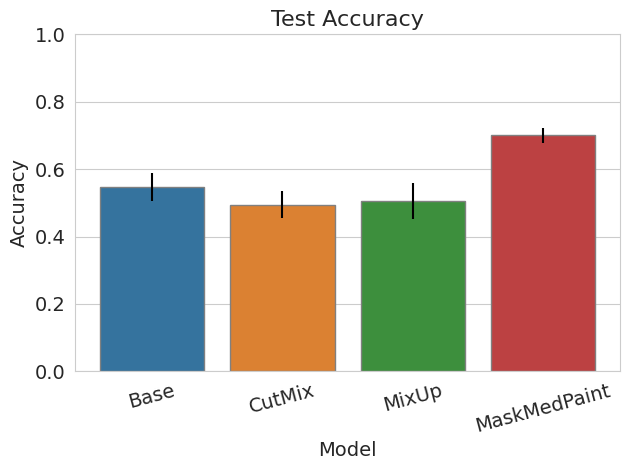

/tmp/ipykernel_1848278/2070922655.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5",


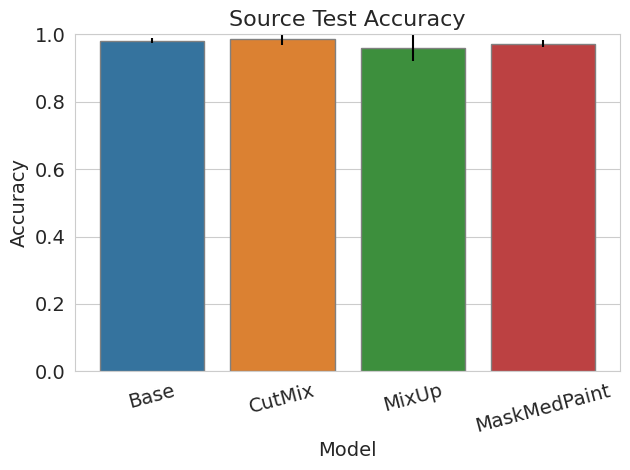

/tmp/ipykernel_1848278/2070922655.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5",


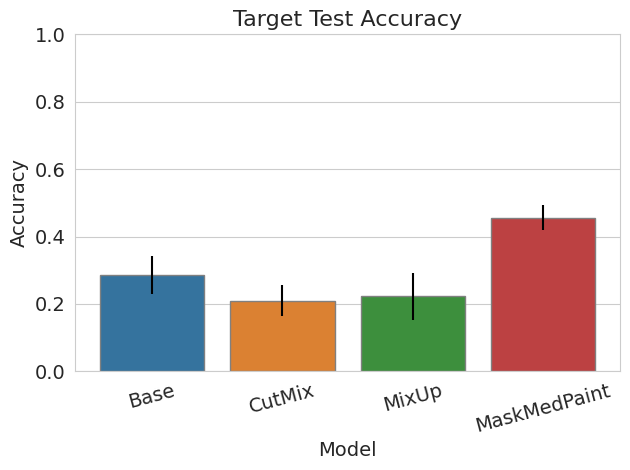

/tmp/ipykernel_1848278/2070922655.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5",


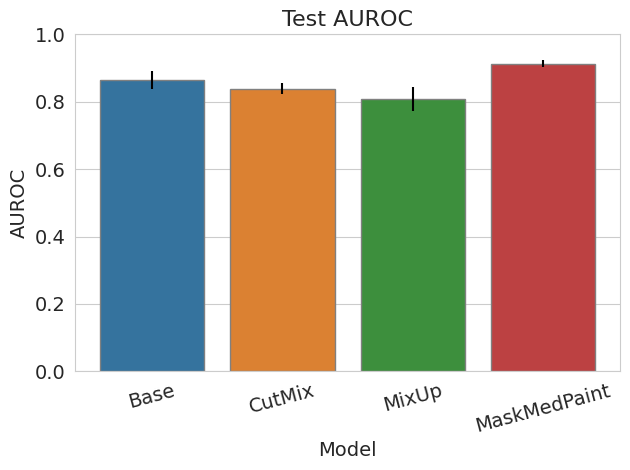

/tmp/ipykernel_1848278/2070922655.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5",


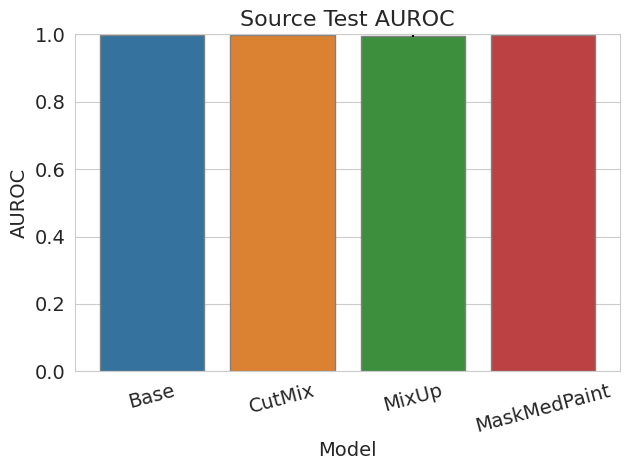

/tmp/ipykernel_1848278/2070922655.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5",


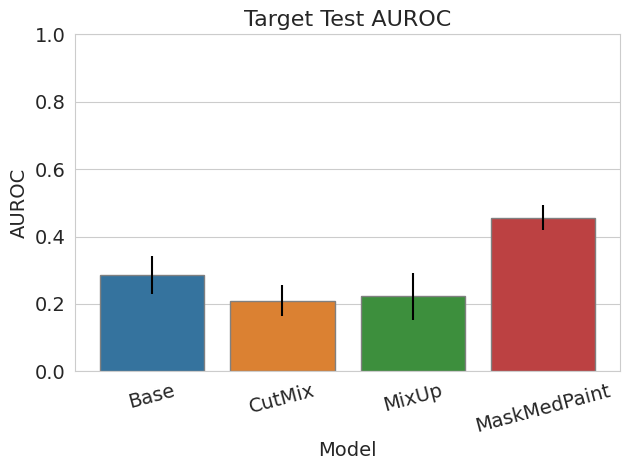

In [94]:
# models = ["base", 
#           "cutmix", "mixup", 
#           "diffusion_0.9"]

for setting in all_settings: 
    suffix = setting[0]
    df = setting[1]

    # df = df[df['model'].isin(models)]
    df = df.reset_index(drop=True)
    
    ax = sns.barplot(df,x="Model", y="mean", hue="Model", edgecolor=".5", 
                     palette=sns.color_palette("tab10"), 
                     saturation=.7,
                     alpha=1.)
    ax.errorbar(x=df["Model"], y=df["mean"], 
                yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none", c="k")
    
    if suffix == 'acc':
        plt.title("Test Accuracy", fontsize=16)
        plt.ylabel("Accuracy", fontsize=14)
    elif suffix == 'in_acc': 
        plt.title("Source Test Accuracy", fontsize=16)
        plt.ylabel("Accuracy", fontsize=14)
    elif suffix == 'out_acc': 
        plt.title("Target Test Accuracy", fontsize=16)
        plt.ylabel("Accuracy", fontsize=14)
    elif suffix == 'auc':
        plt.title("Test AUROC", fontsize=16)
        plt.ylabel("AUROC", fontsize=14)
    elif suffix == 'in_auc': 
        plt.title("Source Test AUROC", fontsize=16)
        plt.ylabel("AUROC", fontsize=14)
    elif suffix == 'out_auc': 
        plt.title("Target Test AUROC", fontsize=16)
        plt.ylabel("AUROC", fontsize=14)
        
    plt.ylim(0., 1.)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=15, fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"iwildcam_figs/iwildcam_{shift}_{suffix}.png", dpi=300)
    plt.show()

## Ablation (Real Images)

In [387]:
shift = "grayscale-to-color"
res_dirs = {
    10: "/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v2", 
    50: "/mnt/scratch-lids/scratch/qixuanj/iwildcam_results_v3", 
    100: "/mnt/scratch-lids/scratch/qixuanj/iwildcam_results"
}

In [404]:
df_ablation = pd.DataFrame(columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])
for num_images, res_dir in res_dirs.items(): 
    df_bacc_mean = pd.read_csv(f"{res_dir}/{shift}/transfer_baccs.csv")
    df_in_acc_mean = pd.read_csv(f"{res_dir}/{shift}/transfer_in_accs.csv")
    df_out_acc_mean = pd.read_csv(f"{res_dir}/{shift}/transfer_out_accs.csv")
    df_ablation = pd.concat([df_ablation, pd.DataFrame([['acc', num_images, df_bacc_mean['mean'].iloc[0], 
                                                        df_bacc_mean['mean_lower_95_err'].iloc[0], 
                                                         df_bacc_mean['mean_upper_95_err'].iloc[0],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])], 
                            ignore_index=True)
    df_ablation = pd.concat([df_ablation, pd.DataFrame([['in_acc', num_images, df_in_acc_mean['mean'].iloc[0], 
                                                        df_in_acc_mean['mean_lower_95_err'].iloc[0], 
                                                         df_in_acc_mean['mean_upper_95_err'].iloc[0],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])], 
                            ignore_index=True)
    df_ablation = pd.concat([df_ablation, pd.DataFrame([['out_acc', num_images, df_out_acc_mean['mean'].iloc[0], 
                                                        df_out_acc_mean['mean_lower_95_err'].iloc[0], 
                                                         df_out_acc_mean['mean_upper_95_err'].iloc[0],]], 
                                                      columns = ['metric', 'num_images', 'mean', 'mean_lower_95_err', 'mean_upper_95_err'])], 
                            ignore_index=True)
    

In [401]:
df_ablation

,metric,num_images,mean,mean_lower_95,mean_upper_95
0,acc,10,0.720704,0.030227,0.030227
1,in_acc,10,0.981481,0.029739,0.029739
2,out_acc,10,0.445864,0.019811,0.019811
3,acc,50,0.838847,0.050956,0.050956
4,in_acc,50,0.953175,0.016556,0.016556
5,out_acc,50,0.690610,0.098832,0.098832
6,acc,100,0.887993,0.040915,0.040915
7,in_acc,100,0.976087,0.013314,0.013314
8,out_acc,100,0.773276,0.079558,0.079558


In [406]:
df

,metric,num_images,mean,mean_lower_95_err,mean_upper_95_err
2,out_acc,10,0.445864,0.019811,0.019811
5,out_acc,50,0.690610,0.098832,0.098832
8,out_acc,100,0.773276,0.079558,0.079558


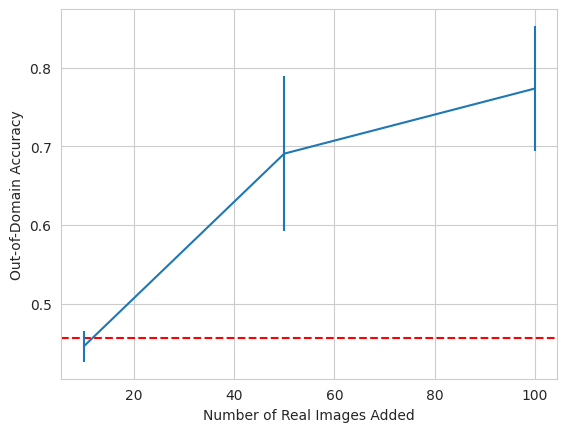

In [412]:
df = df_ablation[df_ablation['metric'] == 'out_acc']
plt.plot(df['num_images'], df['mean'])
# grayscale-to-color
plt.axhline(y=0.456, color='red', linestyle='--')
plt.errorbar(x=df["num_images"], y=df["mean"], 
                yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none")
plt.ylabel("Out-of-Domain Accuracy")
plt.xlabel("Number of Real Images Added")
plt.savefig(f"results/iwildcam_{shift}_out_acc_real.png", dpi=300)
plt.show()

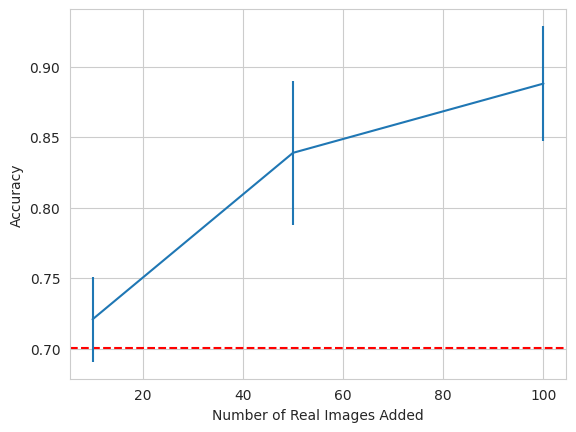

In [414]:
df = df_ablation[df_ablation['metric'] == 'acc']
plt.plot(df['num_images'], df['mean'])
# grayscale-to-color
plt.axhline(y=0.700224592, color='red', linestyle='--')
plt.errorbar(x=df["num_images"], y=df["mean"], 
                yerr = df[['mean_lower_95_err', 'mean_upper_95_err']].T, fmt="none")
plt.ylabel("Accuracy")
plt.xlabel("Number of Real Images Added")
plt.savefig(f"results/iwildcam_{shift}_acc_real.png", dpi=300)
plt.show()